#COMP 551 - Assignment 3

**Group Number:** 44<br><br>
**Members:**
  * **Ayaz Ciplak** - 261013785<br>
  * **Jackie Silver** - 261012002<br>
  * **Christopher Smith** - 261013926<br><br>

***Notes:***
  * *Rename/save this file as code.ipynb before submitting*

### **Task 1: Acquire the Data**

In this section, we will provide functionality for loading and preprocessing the input data for our MLP.

**This section will include the following subsections:**
* Package Installation and Imports
* Initial Data Preprocessing
* _Possibly more configs?_

#### Package Installation and Imports

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=27e436451d556cefbd685f4dfa8288bfcf41d0d33cde3dfeaf61375164bd4ca1
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import medmnist
from medmnist import OrganAMNIST
from typing import Callable, List

from torchvision import datasets, transforms # Transformation Pipeline
from torch.utils.data import DataLoader, TensorDataset # PyTorch Data Loader
import torch

# 3.6
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# 3.8
import torchvision.models as models
from torchvision.models.resnet import ResNet, BasicBlock

#### Initial Data Preprocessing

This subsection includes the retrieval of the train and test datasets, as well as data normalization and flattening using PyTorch transformation pipelines and dataloaders.

_More information on configuring MedMNIST datasets can be found [here](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb)._


In [ ]:
def to_one_hot(label, num_classes=11):
  one_hot = torch.zeros(num_classes)
  one_hot[label] = 1.0
  return one_hot

# Custom dataset class to apply one-hot encoding to labels
class CustomOrganAMNIST(OrganAMNIST):
  """
  This class converts our data into input formats that are more easily
  usable with the MLP model implemented below.

  -> Image transformations:
  OrganAMNIST image data points are originally stored in a 4D array of dimensions:
  [(num_points) x (1) x (num_row_pixels) x (num_col_pixels)]. We want to convert these
  into dimensions [(num_points) x (pixels)]

  -> Label transformations:
  OrganAMNIST label data points are originally integers between 0 and 10,
  representing the organ class the corresponding image is classified into.

  This class converts the label set into a one-hot encoding format,
  where each label is now an array of length 11 and s.t. sum(arr) = 1.
  """
  def __getitem__(self, index):
    # Get the original image and target label
    image, target = super().__getitem__(index)

    # Check if there are null values in the dataset
    if torch.isnan(image).any():
      raise ValueError(f"NaN values found in image at index {index}")

    # Flatten each image to a 1D array (from [1, 28, 28], to [784])
    image = image.view(-1)

    # Convert target label to one-hot encoding
    target = to_one_hot(target, num_classes=11)

    return image, target

In [ ]:
print("Using MedMNIST version:", medmnist.__version__, "\n")

# Define preprocessing transformations
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
    ])

# Load datasets using custom image and data encoding
train_dataset = CustomOrganAMNIST(split="train", transform = transformations, download=True)
val_dataset = CustomOrganAMNIST(split="val", transform = transformations, download=True)
test_dataset = CustomOrganAMNIST(split="test", transform=transformations, download=True)

print("\nTrain Dataset:\n")
print(train_dataset)
print("\n------------------------------------------------------\n")
print("\nValidation Dataset:\n")
print(val_dataset)
print("\n------------------------------------------------------\n")
print("Test Dataset:\n")
print(test_dataset)

print("\nDataset types:", type(train_dataset), type(test_dataset))


Using MedMNIST version: 3.0.2 

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz

Train Dataset:

Dataset CustomOrganAMNIST of size 28 (organamnist)
    Number of datapoints: 34561
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34561, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain th

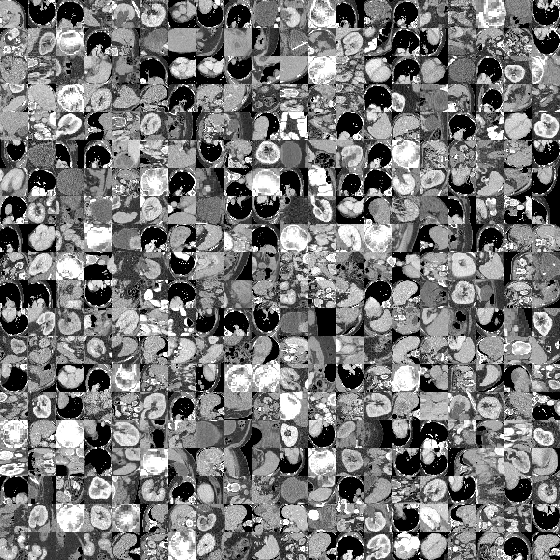

In [ ]:
# We can now illustrate some elements of our dataset
train_dataset.montage(length=20)

In [ ]:
# Demonstration: Within our GradientDescent class, we will use DataLoaders to manage shuffling and splitting data by batches
# In this block of code, we will explore how to use DataLoaders.

# E.g. here, we can use a DataLoader to split our train data into shuffled batches of size 128
train_loader = DataLoader(dataset=train_dataset, batch_size = 128, shuffle=True)

# Note: This will enumerate (num_batches) times, where num_batches = total_samples/batch_size
for batch_index, (images, labels) in enumerate(train_loader):

  ### Images Analysis ###
  print("Original shape - Images:", images.shape)
  print("E.g. Sample of one image data point:", images[0][:32], "...")

  ### Labels Analysis ###
  print("Original shape - Labels:", labels.shape) # Dimensions N x output_dim
  print("E.g. Sample of labels:", labels[:10])

  # We have already applied a transformation to the labels in our
  # dataset, so no conversion needs to be made to the label set.

  break # Only one iteration


Original shape - Images: torch.Size([128, 784])
E.g. Sample of one image data point: tensor([ 1.0000, -0.2157, -0.2078, -1.0000, -1.0000, -1.0000, -0.0196, -0.1451,
         0.1765,  0.1686,  0.3176,  0.4353,  0.4510, -0.3333, -0.4588, -0.6235,
        -0.3882, -0.8667, -0.8980, -0.8118, -0.2235,  0.4510, -0.7098, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  0.2392, -0.1843, -1.0000]) ...
Original shape - Labels: torch.Size([128, 11])
E.g. Sample of labels: tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0

### **Task 2: Implement a Multilayer Perceptron**

In this section, we will implement our MLP model as a Python class. We will include the following subsections:
- Gradient Descent Executor Class
- Model Class
- Activation Function Definitions


#### Gradient Descent Executor Class

In [ ]:
class GradientDescent:
    """
    Configures execution of gradient method for our MLP class.
    Specifies the following hyperparameters:
      - max_iters
      - learning_rate
      - epsilon (If gradients become smaller than this value, execution will stop.)

    """

    def __init__(
        self,
        learning_rate=.001,
        max_iters=1e4,
        epsilon=1e-8,
        batch_size=128):
        """
        Initialize our optimizer with appropriate hyperparameters.
        """
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.iters = 0  #num of iters reached before convergence
        self.norms = np.array([np.inf])

    def run(self, gradient_fn, x, y, params):

        # Initialize new DataLoader to shuffle and split data
        x_d = torch.tensor(x, dtype=torch.float32)
        y_d = torch.tensor(y, dtype=torch.float32)
        curr_dataset = TensorDataset(x_d, y_d)
        curr_dataloader = DataLoader(curr_dataset, batch_size=self.batch_size, shuffle=True)

        norms = np.array([np.inf])
        t = 1


        #for epoch in range(int(self.max_iters / len(curr_dataloader))):
        for epoch in range(int(self.max_iters)):

          for images, labels in curr_dataloader:

            # Convert images and labels from tensors to numpy arrays
            images = images.detach().numpy()
            labels = labels.detach().numpy()

            grad = gradient_fn(images, labels, params)
            for p in range(len(params)):
              weights, biases = params[p]
              grad_w, grad_b = grad[p]
              params[p] = (weights - self.learning_rate*grad_w, biases - self.learning_rate*grad_b)

            t += 1
            norms = np.array([np.linalg.norm(g[0]) + np.linalg.norm(g[1]) for g in grad])

            # Additional check: We have reached max iterations or a small enough norm within a dataloader
            if t >= self.max_iters or np.any(norms < self.epsilon):
              self.norms = norms
              self.iters = t
              return params

        self.norms = norms
        self.iters = t
        return params



#### Activation Function Definitions

Below, we define a variety of activation functions and their derivatives. These are to be used as input parameters to our MLP model.

In [ ]:
### Here, we can define a variety of activation functions that we could use wihtin our model, as well as their corresponding derivative formats
logistic = lambda z: 1./ (1 + np.exp(-z))
logistic_derivative = lambda z: logistic(z) * (1 - logistic(z))

relu = lambda z: np.maximum(0, z)
relu_derivative = lambda z: np.where(z > 0, 1, 0)

leaky_relu_alpha = 0.01 # Defines how steep the decline is when z is below zero
leaky_relu = lambda z: np.where(z > 0, z, leaky_relu_alpha*z)
leaky_relu_derivative = lambda z: np.where(z > 0, 1, leaky_relu_alpha)

softmax = lambda z: np.exp(z - np.max(z, axis=1, keepdims=True)) / (np.sum(np.exp(z - np.max(z, axis=1, keepdims=True)), axis=1, keepdims=True) + 1e-9)
 # Typically only used in the output layer -> We don't need its derivative

tanh = lambda z: np.tanh(z)
tanh_derivative = lambda z: 1 - np.tanh(z)**2


#### Model Class - General

In [ ]:
class MLP:
  """
  Defines a general MLP model with any amount of hidden layers, each with any amount of hidden units.

  Trains on an input dataset X through the fit() function, and makes predictions based on the predict() function.
  """

  def __init__(
      self,
      activation : Callable,
      activation_derivative: Callable,
      output_activation: Callable,
      output_activation_derivative: Callable,
      is_verbose: bool,
      M: List[int] = [64],
      output_dim: int = 1
  ):
    """
    Initializes our model with the following configurations:
      - activation: The activation function used at each hidden layer
      - activation_derivative: A function corresponding to the derivative of the activation function. Used in gradient computation.
      - output_activation: The activation function used at the output layer
      - output_activation_derivative: A function corresponding to the derivative of the output activation function. Used in gradient computation.
      - is_verbose: Indicates whether the model should print information about the computations it is making. Should NOT be used with high amount of iterations.
      - M: Specifies the number of hidden units in each hidden layer. Order is [|W0|, |W1|, ...] where our model is y_hat = h(Wn h(... h(W0*x + b0) + b1)....)
        - Note: Len(M) = num of hidden layers.
      - output_dim: Specifies the dimension of the output layer, i.e. how many output values should be predicted for each input.
    """
    self.activation = activation
    self.activation_derivative = activation_derivative
    self.output_activation = output_activation
    self.output_activation_derivative = output_activation_derivative
    self.is_verbose = is_verbose
    self.M = M
    self.num_hidden_layers = len(M)
    self.output_dim = output_dim


  def fit(self, x, y, optimizer):
    """
    Trains weights based on training input set x and training input set y.
    Inputs:
      - x: Input data, of dimensions N x D where N is the number of individual data points and D is the number of features per data point.
      - y: Output data, of dimensions N x output_dim where output_dim is the number of ouput data points produced per input data point.
      - optimizer: Specifies hyperparameters (e.g. learning rate, max_iterations) for gradient descent configuration

      TODO: Enforce types for x, y inputs
    """
    N, D = x.shape

    # Initialize weights and biases
    params0, curr_input_dim = [], D

    for i in range(self.num_hidden_layers):
      weights = np.random.randn(curr_input_dim, self.M[i]) * 0.01 # Shape: cols(prev) x |Wi|
      biases = np.zeros(self.M[i]) # len(biases) = |Wi|
      params0.append((weights, biases))
      curr_input_dim = self.M[i] # Update input dim for next layer

      if self.is_verbose:
        print("\nFor layer", i, "with num of hidden units", self.M[i], ", dim(weights) = ", weights.shape, "and dim(biases) =", 1, len(biases))

      # Initialize output layer weights and biases
    last_w = np.random.randn(curr_input_dim, self.output_dim) * 0.01
    last_b_w = np.zeros(self.output_dim)
    params0.append((last_w, last_b_w))

    if self.is_verbose:
      print("\nFor output layer with num of hidden units", self.output_dim, "dim(weights) =", last_w.shape, "and dim(biases) =", 1, len(last_b_w))


    def gradient(x, y, params):
      """
      Computes one iteration of gradient descent. Hyperparameters like learning rate,
      max_iterations, etc. are controlled by the optimizer.

      Inputs:
        - x, y: See fit() description for details.
        - params: Holds current configurations of all weights and biases
      """

      # Store gradients and n-1th outputs
      gradients, layer_outputs = [], [x]

      if self.is_verbose:
        print("Running an iteration of gradient computation. Current input has dimensions", layer_outputs[0].shape)
        print("\nBeginning forward pass.")


      ### Forward Pass ###
      for i in range(self.num_hidden_layers):
        weight, bias = params[i] # Unpack current params at layer i
        z = np.dot(layer_outputs[-1], weight) + bias # = c*Wi, where c is the previous layer's outputs (initially x)
        layer_output = self.activation(z) # Apply hidden activation fn
        layer_outputs.append(layer_output)

        if self.is_verbose:
          print("Executed forward pass for hidden layer", i)
          print("Current multiplier (c) dimensions:", layer_outputs[-2].shape, "current multipicand (Wi) dimensions:", weight.shape)
          print("Produced output z = h(c*Wi + bi) of dimensions:", layer_outputs[-1].shape)

      # Forward pass for output layer
      final_weight, final_bias = params[-1]
      output = np.dot(layer_outputs[-1], final_weight) + final_bias
      yh = self.output_activation(output)

      if self.is_verbose:
        print("Executed forward pass for output layer.")
        print("Current multiplier (c) dimensions:", layer_outputs[-1].shape, "current multipicand (Wn) dimensions:", final_weight.shape)
        print("Produced output z = h(c*Wi + bi) of dimensions:", yh.shape)
        print("\n\nBeginning Backwards Pass.")


      ### Backward Pass ###

      # Backprop for output layer
      dL_dy_hat = (yh - y) / N # Error
      dL_dz_out = dL_dy_hat * self.output_activation_derivative(output) # Apply derivative
      dL_dW_out = np.dot(layer_outputs[-1].T, dL_dz_out)
      dL_db_out= np.sum(dL_dz_out, axis=0)

      gradients.append((dL_dW_out, dL_db_out)) # Output gradient

      if self.is_verbose:
        print("Computed output weight gradient of shape:", dL_dW_out.shape, "output bias gradients of shape:", dL_db_out.shape)

      dL_dz = np.dot(dL_dz_out, final_weight.T)   # Initial gradient for last hidden layer

      # Backprop for hidden layers
      for i in range(self.num_hidden_layers - 1, -1, -1):
        z = np.dot(layer_outputs[i], params[i][0]) + params[i][1]
        dL_dz *= self.activation_derivative(z)

        dL_dW = np.dot(layer_outputs[i].T, dL_dz)
        dL_db = np.sum(dL_dz, axis=0)
        gradients.insert(0, (dL_dW, dL_db)) # Insert gradient at beginning of array

        if self.is_verbose:
          print("For weight set", i, ", Produced output weight gradient of shape:", dL_dW.shape, "biases gradient of shape:", dL_db.shape)

        # Compute dL_dz for next layer back
        if i > 0:
          dL_dz = np.dot(dL_dz, params[i][0].T)

      return gradients

    self.params = optimizer.run(gradient, x, y, params0) # Execute gradient function according to optimizer configs
    return self

  def predict(self, x):
    """
    Generates and returns output set predictions from an input set x based on current weight predictions.
    Should be called after fit().
    """

    # Forward pass based on trained weights
    for i in range(self.num_hidden_layers):
      weight, bias = self.params[i]
      x = self.activation(np.dot(x, weight) + bias)
    final_weight, final_bias = self.params[-1]
    linear_output = np.dot(x, final_weight) + final_bias
    yh = self.output_activation(linear_output)

    if self.is_verbose:
      print("Computed predictions of dimensions:", yh.shape)

    return yh


  def evaluate_acc(y, y_hat):
    """
    Evaluates the model's accuracy. Takes as input the true output labels (y) and the ones predicted by the class (y_hat) for a given
    input dataset.
    """
    pass


#### Model Class - Classification

In [ ]:
class ClassificationMLP:
  """
  Slight modification to the general MLP model, implements classification (e.g. softmax activation function)
  Trains on an input dataset X through the fit() function, and makes predictions based on the predict() function.
  """

  def __init__(
      self,
      activation : Callable,
      activation_derivative: Callable,
      is_verbose: bool,
      M: List[int] = [64],
      output_dim: int = 1
  ):
    """
    Initializes our model with the following configurations:
      - activation: The activation function used at each hidden layer
      - activation_derivative: A function corresponding to the derivative of the activation function. Used in gradient computation.
      - is_verbose: Indicates whether the model should print information about the computations it is making. Should NOT be used with high amount of iterations.
      - M: Specifies the number of hidden units in each hidden layer. Order is [|W0|, |W1|, ...] where our model is y_hat = h(Wn h(... h(W0*x + b0) + b1)....)
        - Note: Len(M) = num of hidden layers.
      - output_dim: Specifies the dimension of the output layer, i.e. how many output values should be predicted for each input.
    """
    self.activation = activation
    self.activation_derivative = activation_derivative
    self.output_activation = softmax
    self.is_verbose = is_verbose
    self.M = M
    self.num_hidden_layers = len(M)
    self.output_dim = output_dim


  def fit(self, x, y, optimizer):
    """
    Trains weights based on training input set x and training input set y.
    Inputs:
      - x: Input data, of dimensions N x D where N is the number of individual data points and D is the number of features per data point.
      - y: Output data, of dimensions N x output_dim where output_dim is the number of ouput data points produced per input data point.
      - optimizer: Specifies hyperparameters (e.g. learning rate, max_iterations) for gradient descent configuration

      TODO: Enforce types for x, y inputs
    """
    N, D = x.shape

    # Initialize weights and biases
    params0, curr_input_dim = [], D

    for i in range(self.num_hidden_layers):
      weights = np.random.randn(curr_input_dim, self.M[i]) * 0.01 # Shape: cols(prev) x |Wi|
      biases = np.zeros(self.M[i]) # len(biases) = |Wi|
      params0.append((weights, biases))
      curr_input_dim = self.M[i] # Update input dim for next layer

      if self.is_verbose:
        print("\nFor layer", i, "with num of hidden units", self.M[i], ", dim(weights) = ", weights.shape, "and dim(biases) =", 1, len(biases))

      # Initialize output layer weights and biases
    last_w = np.random.randn(curr_input_dim, self.output_dim) * 0.01
    last_b_w = np.zeros(self.output_dim)
    params0.append((last_w, last_b_w))

    if self.is_verbose:
      print("\nFor output layer with num of hidden units", self.output_dim, "dim(weights) =", last_w.shape, "and dim(biases) =", 1, len(last_b_w))


    def gradient(x, y, params):
      """
      Computes one iteration of gradient descent. Hyperparameters like learning rate,
      max_iterations, etc. are controlled by the optimizer.

      Inputs:
        - x, y: See fit() description for details.
        - params: Holds current configurations of all weights and biases
      """

      # Store gradients and n-1th outputs
      gradients, layer_outputs = [], [x]

      if self.is_verbose:
        print("Running an iteration of gradient computation. Current input has dimensions", layer_outputs[0].shape)
        print("\nBeginning forward pass.")


      ### Forward Pass ###
      for i in range(self.num_hidden_layers):
        weight, bias = params[i] # Unpack current params at layer i
        z = np.dot(layer_outputs[-1], weight) + bias # = c*Wi, where c is the previous layer's outputs (initially x)
        layer_output = self.activation(z) # Apply hidden activation fn
        layer_outputs.append(layer_output)

        if self.is_verbose:
          print("Executed forward pass for hidden layer", i)
          print("Current multiplier (c) dimensions:", layer_outputs[-2].shape, "current multipicand (Wi) dimensions:", weight.shape)
          print("Produced output z = h(c*Wi + bi) of dimensions:", layer_outputs[-1].shape)

      # Forward pass for output layer
      final_weight, final_bias = params[-1]
      output = np.dot(layer_outputs[-1], final_weight) + final_bias
      yh = self.output_activation(output)

      if self.is_verbose:
        print("Executed forward pass for output layer.")
        print("Current multiplier (c) dimensions:", layer_outputs[-1].shape, "current multipicand (Wn) dimensions:", final_weight.shape)
        print("Produced output z = h(c*Wi + bi) of dimensions:", yh.shape)
        print("\n\nBeginning Backwards Pass.")


      ### Backward Pass ###

      # Backprop for output layer
      dL_dy_hat = yh - y
      dL_dz_out = dL_dy_hat # Using softmax + cross-entropy loss, the derivative of the loss w.r.t. z is just the diff
      dL_dW_out = np.dot(layer_outputs[-1].T, dL_dz_out)
      dL_db_out= np.sum(dL_dz_out, axis=0)

      gradients.append((dL_dW_out, dL_db_out)) # Output gradient

      if self.is_verbose:
        print("Computed output weight gradient of shape:", dL_dW_out.shape, "output bias gradients of shape:", dL_db_out.shape)

      dL_dz = np.dot(dL_dz_out, final_weight.T)   # Initial gradient for last hidden layer

      # Backprop for hidden layers
      for i in range(self.num_hidden_layers - 1, -1, -1):
        z = np.dot(layer_outputs[i], params[i][0]) + params[i][1]
        dL_dz *= self.activation_derivative(z)

        dL_dW = np.dot(layer_outputs[i].T, dL_dz)
        dL_db = np.sum(dL_dz, axis=0)
        gradients.insert(0, (dL_dW, dL_db)) # Insert gradient at beginning of array

        if self.is_verbose:
          print("For weight set", i, ", Produced output weight gradient of shape:", dL_dW.shape, "biases gradient of shape:", dL_db.shape)

        # Compute dL_dz for next layer back
        if i > 0:
          dL_dz = np.dot(dL_dz, params[i][0].T)

      return gradients

    self.params = optimizer.run(gradient, x, y, params0) # Execute gradient function according to optimizer configs
    return self


  def fit_batch(self, x, y, optimizer, b):
    """
    Trains weights based on training input batch x and training input batch y.
    Inputs:
      - x: Input data, of dimensions N x D where N is the number of individual data points and D is the number of features per data point.
      - y: Output data, of dimensions N x output_dim where output_dim is the number of ouput data points produced per input data point.
      - optimizer: Specifies hyperparameters (e.g. learning rate, max_iterations) for gradient descent configuration

      TODO: Enforce types for x, y inputs
    """

    N, D = x.shape
    curr_input_dim = D

    # Initialize weights and biases
    if b == 0:  # First batch in epoch
      params0 = []

      for i in range(self.num_hidden_layers):
        weights = np.random.randn(curr_input_dim, self.M[i]) * 0.01 # Shape: cols(prev) x |Wi|
        biases = np.zeros(self.M[i]) # len(biases) = |Wi|
        params0.append((weights, biases))
        curr_input_dim = self.M[i] # Update input dim for next layer

        # Initialize output layer weights and biases
      last_w = np.random.randn(curr_input_dim, self.output_dim) * 0.01
      last_b_w = np.zeros(self.output_dim)
      params0.append((last_w, last_b_w))

    else:       # Not first batch in epoch, init params with past fitting's params
      params0 = self.params

    if self.is_verbose:
      print("\nFor output layer with num of hidden units", self.output_dim, "dim(weights) =", last_w.shape, "and dim(biases) =", 1, len(last_b_w))


    def gradient(x, y, params):
      """
      Computes one iteration of gradient descent. Hyperparameters like learning rate,
      max_iterations, etc. are controlled by the optimizer.

      Inputs:
        - x, y: See fit() description for details.
        - params: Holds current configurations of all weights and biases
      """

      # Store gradients and n-1th outputs
      gradients, layer_outputs = [], [x]

      if self.is_verbose:
        print("Running an iteration of gradient computation. Current input has dimensions", layer_outputs[0].shape)
        print("\nBeginning forward pass.")


      ### Forward Pass ###
      for i in range(self.num_hidden_layers):
        weight, bias = params[i] # Unpack current params at layer i
        z = np.dot(layer_outputs[-1], weight) + bias # = c*Wi, where c is the previous layer's outputs (initially x)
        layer_output = self.activation(z) # Apply hidden activation fn
        layer_outputs.append(layer_output)

        if self.is_verbose:
          print("Executed forward pass for hidden layer", i)
          print("Current multiplier (c) dimensions:", layer_outputs[-2].shape, "current multipicand (Wi) dimensions:", weight.shape)
          print("Produced output z = h(c*Wi + bi) of dimensions:", layer_outputs[-1].shape)

      # Forward pass for output layer
      final_weight, final_bias = params[-1]
      output = np.dot(layer_outputs[-1], final_weight) + final_bias
      yh = self.output_activation(output)

      if self.is_verbose:
        print("Executed forward pass for output layer.")
        print("Current multiplier (c) dimensions:", layer_outputs[-1].shape, "current multipicand (Wn) dimensions:", final_weight.shape)
        print("Produced output z = h(c*Wi + bi) of dimensions:", yh.shape)
        print("\n\nBeginning Backwards Pass.")


      ### Backward Pass ###

      # Backprop for output layer
      dL_dy_hat = yh - y
      dL_dz_out = dL_dy_hat # Using softmax + cross-entropy loss, the derivative of the loss w.r.t. z is just the diff
      dL_dW_out = np.dot(layer_outputs[-1].T, dL_dz_out)
      dL_db_out= np.sum(dL_dz_out, axis=0)

      gradients.append((dL_dW_out, dL_db_out)) # Output gradient

      if self.is_verbose:
        print("Computed output weight gradient of shape:", dL_dW_out.shape, "output bias gradients of shape:", dL_db_out.shape)

      dL_dz = np.dot(dL_dz_out, final_weight.T)   # Initial gradient for last hidden layer

      # Backprop for hidden layers
      for i in range(self.num_hidden_layers - 1, -1, -1):
        z = np.dot(layer_outputs[i], params[i][0]) + params[i][1]
        dL_dz *= self.activation_derivative(z)

        dL_dW = np.dot(layer_outputs[i].T, dL_dz)
        dL_db = np.sum(dL_dz, axis=0)
        gradients.insert(0, (dL_dW, dL_db)) # Insert gradient at beginning of array

        if self.is_verbose:
          print("For weight set", i, ", Produced output weight gradient of shape:", dL_dW.shape, "biases gradient of shape:", dL_db.shape)

        # Compute dL_dz for next layer back
        if i > 0:
          dL_dz = np.dot(dL_dz, params[i][0].T)

      return gradients

    self.params = optimizer.run(gradient, x, y, params0) # Execute gradient function according to optimizer configs
    return self

  def predict(self, x):
    """
    Generates and returns output set predictions from an input set x based on current weight predictions.
    Should be called after fit().
    """

    # Forward pass based on trained weights
    for i in range(self.num_hidden_layers):
      weight, bias = self.params[i]
      x = self.activation(np.dot(x, weight) + bias)
    final_weight, final_bias = self.params[-1]
    linear_output = np.dot(x, final_weight) + final_bias
    yh = self.output_activation(linear_output)

    if self.is_verbose:
      print("Computed predictions of dimensions:", yh.shape)

    return yh


  @staticmethod # Instance-agnostic
  def evaluate_acc(y, y_hat):
    """
    Evaluates the model's accuracy. Takes as input the true output labels (y) and the ones predicted by the class (y_hat) for a given
    input dataset.

    In the case of classification, we can determine this loss as categorical accuracy,
    i.e. whether the predicted class's highest-probability entry matches the actual class.

    - Both arguments should be of the shape N x num_classes (where num_classes = output_shape)
    """
    y_pred_class = np.argmax(y_hat, axis=1)
    y_true_class = np.argmax(y, axis=1)

    cat_accuracy = np.mean(y_pred_class == y_true_class)

    return cat_accuracy


### **Task 3: Run the Experiments and Report**

This section will involve running a variety of tests based on our previous MLP implementation and other types of MLP models. It will include the following subsections:

* Nonlinearity and Network Depth Comparison
* Activation Function Comparison - Tanh vs. Leaky-ReLU
* Regularization Implementation and Analysis - L1 & L2
* Non-Normalized Input Data Analysis
* Higher-Complexity Input Data Comparison
* CNN vs. MLP Comparison
* CNN with Higher-Complexity Input Data Analysis
* Altered Pre-Trained Model vs. MLP and CNN Comparison
* Number of Training Epochs Analysis - MLP, CNN and Pre-Trained Model
* _Additional Experiments_
* _Justification - Hyperparameter choices_

#### **3.1 - Nonlinearity and Network Depth Comparison**

In [ ]:
# First, we can extract our x and y datasets.

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

x, y = None, None

for x_elems, y_elems in train_loader:
  x = x_elems
  y = y_elems

print(x.shape) # N x D
print(y.shape) # N x output_dim

print("Converting to NumPy arrays...")
x = x.detach().numpy()
y = y.detach().numpy()
print(x.shape)
print(y.shape)

torch.Size([34561, 784])
torch.Size([34561, 11])
Converting to NumPy arrays...
(34561, 784)
(34561, 11)


In [ ]:
# Next, we can extract our test x_test and y_test datasets.

validation_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

x_val, y_val = None, None

for x_elems, y_elems in validation_loader:
  x_val = x_elems
  y_val = y_elems

print(x_val.shape) # N x D
print(y_val.shape) # N x output_dim

print("Converting to NumPy arrays...")
x_val = x_val.detach().numpy()
y_val = y_val.detach().numpy()
print(x_val.shape)
print(y_val.shape)

torch.Size([6491, 784])
torch.Size([6491, 11])
Converting to NumPy arrays...
(6491, 784)
(6491, 11)


In [ ]:
# Now, we can create our models
no_layer_model = ClassificationMLP(
    activation = relu, # Will not be used anyways
    activation_derivative = relu_derivative, # Will not be used anyways
    is_verbose = False,
    M = [], # No hidden layers
    output_dim = 11
)

one_layer_model = ClassificationMLP(
    activation = relu,
    activation_derivative = relu_derivative,
    is_verbose = False,
    M = [256], # No hidden layers
    output_dim = 11
)

two_layer_model = ClassificationMLP(
    activation = relu,
    activation_derivative = relu_derivative,
    is_verbose = False,
    M = [256, 256], # No hidden layers
    output_dim = 11
)

task_1_models = [no_layer_model, one_layer_model, two_layer_model]
# We can also define 4 optimizers - We will compare each model's resuls with
# 4 different amounts of max-iterations, keeping the other hyperparameter values constant.

optimizer_low_iter = GradientDescent(learning_rate = 0.005, max_iters = 500, epsilon=1e-9, batch_size=64)
optimizer_mid_iter = GradientDescent(learning_rate = 0.005, max_iters = 1000, epsilon=1e-9, batch_size=64)
optimizer_high_iter = GradientDescent(learning_rate = 0.005, max_iters = 2000, epsilon=1e-9, batch_size=64)
optimizer_very_high_iter = GradientDescent(learning_rate = 0.005, max_iters = 12500, epsilon=1e-9, batch_size=64)



In [ ]:
# We define a helper function to facilitate measuring accuracies
def train_and_eval_classification(model, optimizer, x, y, x_val, y_val, train_acc_array, val_acc_array):
  trained_model = model.fit(x, y, optimizer)
  train_acc = ClassificationMLP.evaluate_acc(y, trained_model.predict(x))
  val_acc = ClassificationMLP.evaluate_acc(y_val, trained_model.predict(x_val))
  train_acc_array.append(train_acc)
  val_acc_array.append(val_acc)



In [ ]:
# Measuring categorical accuracy for low iterations
low_iter_train_accuracies = []
low_iter_val_accuracies = []

for model in task_1_models:
  train_and_eval_classification(model, optimizer_low_iter, x, y, x_val, y_val, low_iter_train_accuracies, low_iter_val_accuracies)

print("Train accuracies (0, 1, 2 layers):", low_iter_train_accuracies)
print("Validation accuracies (0, 1, 2 layers):", low_iter_val_accuracies)

Train accuracies (0, 1, 2 layers): [0.7866381181100084, 0.886577355979283, 0.8864326842394606]
Validation accuracies (0, 1, 2 layers): [0.8457864735788014, 0.8870744107225389, 0.9049453088892312]


In [ ]:
# Measuring categorical accuracy for medium iterations
mid_iter_train_accuracies = []
mid_iter_val_accuracies = []

for model in task_1_models:
  train_and_eval_classification(model, optimizer_mid_iter, x, y, x_val, y_val, mid_iter_train_accuracies, mid_iter_val_accuracies)

print("Train accuracies (0, 1, 2 layers):", mid_iter_train_accuracies)
print("Validation accuracies (0, 1, 2 layers):", mid_iter_val_accuracies)

Train accuracies (0, 1, 2 layers): [0.8028702873180753, 0.9577269176239114, 0.9526923410780938]
Validation accuracies (0, 1, 2 layers): [0.8400862733014943, 0.898474811277153, 0.9141888769064859]


In [ ]:
# Measuring categorical accuracy for high iterations
high_iter_train_accuracies = []
high_iter_val_accuracies = []

for model in task_1_models:
  train_and_eval_classification(model, optimizer_high_iter, x, y, x_val, y_val, high_iter_train_accuracies, high_iter_val_accuracies)

print("Train accuracies (0, 1, 2 layers):", high_iter_train_accuracies)
print("Validation accuracies (0, 1, 2 layers):", high_iter_val_accuracies)

Train accuracies (0, 1, 2 layers): [0.8156014004224414, 0.9890338821214664, 0.9826104568733544]
Validation accuracies (0, 1, 2 layers): [0.8262209212756124, 0.911723925435218, 0.9144969958403943]


In [ ]:
# Measuring categorical accuracy for very high iterations
very_high_iter_train_accuracies = []
very_high_iter_val_accuracies = []

for model in task_1_models:
  # Fit model on training data
  train_and_eval_classification(model, optimizer_very_high_iter, x, y, x_val, y_val, very_high_iter_train_accuracies, very_high_iter_val_accuracies)

print("Train accuracies (0, 1, 2 layers):", very_high_iter_train_accuracies)
print("Validation accuracies (0, 1, 2 layers):", very_high_iter_val_accuracies)

Train accuracies (0, 1, 2 layers): [0.8318046352825439, 0.9999710656520355, 0.9999710656520355]
Validation accuracies (0, 1, 2 layers): [0.7960252657525805, 0.9097211523648128, 0.9103373902326298]


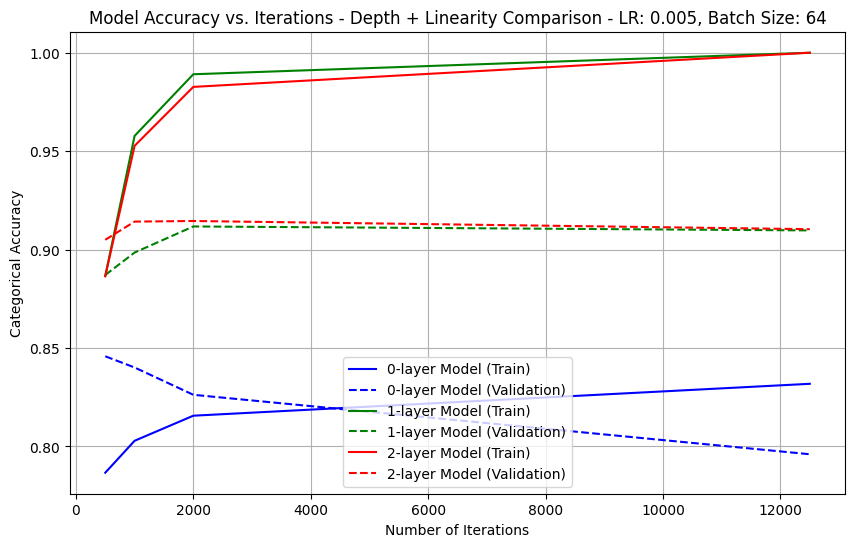

In [ ]:
# We can now visuzalize the train and test accuracies of our 0, 1, and 2-layer models
# relative to different amounts of iterations

train_accuracies = [
    low_iter_train_accuracies,
    mid_iter_train_accuracies,
    high_iter_train_accuracies,
    very_high_iter_train_accuracies
]

val_accuracies = [
    low_iter_val_accuracies,
    mid_iter_val_accuracies,
    high_iter_val_accuracies,
    very_high_iter_val_accuracies
]

zero_layer_model_train_accuracies = [accs[0] for accs in train_accuracies]
zero_layer_model_val_accuracies = [accs[0] for accs in val_accuracies]

one_layer_model_train_accuracies = [accs[1] for accs in train_accuracies]
one_layer_model_val_accuracies = [accs[1] for accs in val_accuracies]

two_layer_model_train_accuracies = [accs[2] for accs in train_accuracies]
two_layer_model_val_accuracies = [accs[2] for accs in val_accuracies]

# Plotting
plt.figure(figsize=(10, 6))

iterations = [500, 1000, 2000, 12500]

# Zero-layer model
plt.plot(iterations, zero_layer_model_train_accuracies, label='0-layer Model (Train)', color='blue', linestyle='-')
plt.plot(iterations, zero_layer_model_val_accuracies, label='0-layer Model (Validation)', color='blue', linestyle='--')

# One-layer model
plt.plot(iterations, one_layer_model_train_accuracies, label='1-layer Model (Train)', color='green', linestyle='-')
plt.plot(iterations, one_layer_model_val_accuracies, label='1-layer Model (Validation)', color='green', linestyle='--')

# Two-layer model
plt.plot(iterations, two_layer_model_train_accuracies, label='2-layer Model (Train)', color='red', linestyle='-')
plt.plot(iterations, two_layer_model_val_accuracies, label='2-layer Model (Validation)', color='red', linestyle='--')

# Labels and legend
plt.xlabel("Number of Iterations")
plt.ylabel("Categorical Accuracy")
plt.title("Model Accuracy vs. Iterations - Depth + Linearity Comparison - LR: 0.005, Batch Size: 64")
plt.legend(loc="best")
plt.grid(True)

plt.show()


**Analysis**

- <u>Effect of iterations on performance:</u>
  - On all models, an increase in interations led to an increase in train performance
  - However, we also see that in all models, increasing the amount of iterations past a certain threshold (in our case, around 2000) leads to overfitting and therefore a decline in test error.

- <u> Effects of nonlinearity and depth on performance: </u>
  - We observe that the linear model struggles to completely fit all classes correctly -- Even on the training categorical accuracy, we do not see accuracies larger than around 85%.
  - The non-linear models perform very similarly in this case -- Their train and test accuracies are very similar across all iteration levels, although it seems the deeper model has an easier time fitting the unseen (test) data with less iterations.
  - _Note that occasionally this plot may be generated with a steep decrease in train/test performance for the 2-layer model. This is caused by numerical instability at higher iteration levels, when the weights get too small to be represented._


#### **3.2 - Activation Function Comparison: Tanh vs. Leaky-ReLU**

In [ ]:
# We will maintain our structure of evaluating the models at different iteration levels for this section.

# First, we can initialize our models.
two_layer_leaky_relu_model = ClassificationMLP(
    activation = leaky_relu,
    activation_derivative = leaky_relu_derivative,
    is_verbose = False,
    M = [256, 256], # No hidden layers
    output_dim = 11
)

two_layer_tanh_model = ClassificationMLP(
    activation = tanh,
    activation_derivative = tanh_derivative,
    is_verbose = False,
    M = [256, 256], # No hidden layers
    output_dim = 11
)

task_2_models = [two_layer_leaky_relu_model, two_layer_tanh_model]


In [ ]:
# Measuring categorical accuracy for low iterations
low_iter_train_accuracies_2 = []
low_iter_val_accuracies_2 = []

for model in task_2_models:
  train_and_eval_classification(model, optimizer_low_iter, x, y, x_val, y_val, low_iter_train_accuracies_2, low_iter_val_accuracies_2)

print("Train accuracies (leaky-ReLU, tanh):", low_iter_train_accuracies_2)
print("Validation accuracies (leaky-ReLU, tanh):", low_iter_val_accuracies_2)

Train accuracies (leaky-ReLU, tanh): [0.8601892306356876, 0.8345533983391684]
Validation accuracies (leaky-ReLU, tanh): [0.8843013403173625, 0.8920043136650747]


In [ ]:
# Measuring categorical accuracy for medium iterations
mid_iter_train_accuracies_2 = []
mid_iter_val_accuracies_2 = []

for model in task_2_models:
  train_and_eval_classification(model, optimizer_mid_iter, x, y, x_val, y_val, mid_iter_train_accuracies_2, mid_iter_val_accuracies_2)

print("Train accuracies (leaky-ReLU, tanh):", mid_iter_train_accuracies_2)
print("Validation accuracies (leaky-ReLU, tanh):", mid_iter_val_accuracies_2)

Train accuracies (leaky-ReLU, tanh): [0.951534967159515, 0.9114319608807615]
Validation accuracies (leaky-ReLU, tanh): [0.9001694654136496, 0.9007857032814667]


In [ ]:
# Measuring categorical accuracy for high iterations
high_iter_train_accuracies_2 = []
high_iter_val_accuracies_2 = []

for model in task_2_models:
  train_and_eval_classification(model, optimizer_high_iter, x, y, x_val, y_val, high_iter_train_accuracies_2, high_iter_val_accuracies_2)

print("Train accuracies (leaky-ReLU, tanh):", high_iter_train_accuracies_2)
print("Validation accuracies (leaky-ReLU, tanh):", high_iter_val_accuracies_2)

Train accuracies (leaky-ReLU, tanh): [0.9912039582188016, 0.971904748126501]
Validation accuracies (leaky-ReLU, tanh): [0.9135726390386689, 0.9092589739639501]


In [ ]:
# Measuring categorical accuracy for very high iterations
very_high_iter_train_accuracies_2 = []
very_high_iter_val_accuracies_2 = []

for model in task_2_models:
  # Fit model on training data
  train_and_eval_classification(model, optimizer_very_high_iter, x, y, x_val, y_val, very_high_iter_train_accuracies_2, very_high_iter_val_accuracies_2)

print("Train accuracies (leaky-ReLU, tanh):", very_high_iter_train_accuracies_2)
print("Validation accuracies (leaky-ReLU, tanh):", very_high_iter_val_accuracies_2)

Train accuracies (leaky-ReLU, tanh): [0.9999710656520355, 1.0]
Validation accuracies (leaky-ReLU, tanh): [0.9205053150516099, 0.9103373902326298]


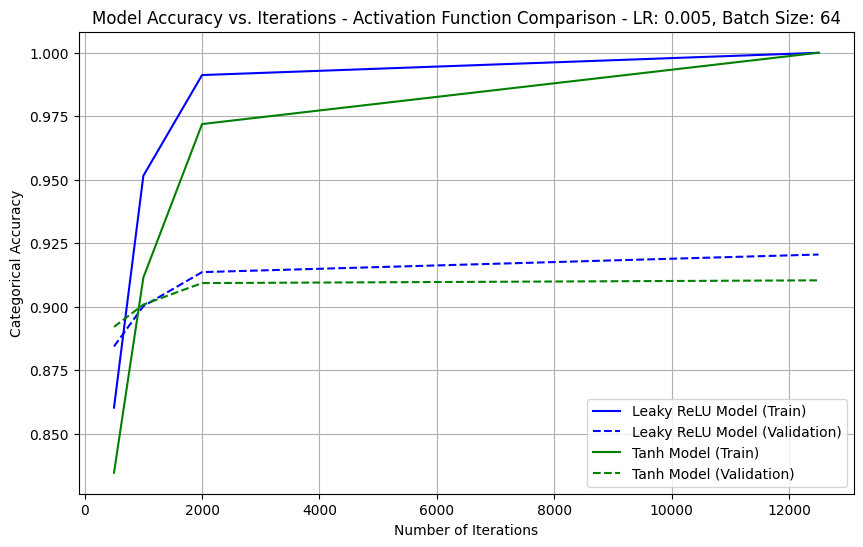

In [ ]:
# We can now visuzalize the train and test accuracies of our leaky ReLU and tanh models
# relative to different amounts of iterations

train_accuracies_2 = [
    low_iter_train_accuracies_2,
    mid_iter_train_accuracies_2,
    high_iter_train_accuracies_2,
    very_high_iter_train_accuracies_2
]

val_accuracies_2 = [
    low_iter_val_accuracies_2,
    mid_iter_val_accuracies_2,
    high_iter_val_accuracies_2,
    very_high_iter_val_accuracies_2
]

leaky_relu_model_train_accuracies_2 = [accs[0] for accs in train_accuracies_2]
leaky_relu_model_val_accuracies_2 = [accs[0] for accs in val_accuracies_2]

tanh_model_train_accuracies_2 = [accs[1] for accs in train_accuracies_2]
tanh_model_val_accuracies_2 = [accs[1] for accs in val_accuracies_2]

# Plotting
plt.figure(figsize=(10, 6))

iterations = [500, 1000, 2000, 12500]

# Leaky ReLU model
plt.plot(iterations, leaky_relu_model_train_accuracies_2, label='Leaky ReLU Model (Train)', color='blue', linestyle='-')
plt.plot(iterations, leaky_relu_model_val_accuracies_2, label='Leaky ReLU Model (Validation)', color='blue', linestyle='--')

# Tanh model
plt.plot(iterations, tanh_model_train_accuracies_2, label='Tanh Model (Train)', color='green', linestyle='-')
plt.plot(iterations, tanh_model_val_accuracies_2, label='Tanh Model (Validation)', color='green', linestyle='--')

# Labels and legend
plt.xlabel("Number of Iterations")
plt.ylabel("Categorical Accuracy")
plt.title("Model Accuracy vs. Iterations - Activation Function Comparison - LR: 0.005, Batch Size: 64")
plt.legend(loc="best")
plt.grid(True)

plt.show()

**Analysis**

We observe two trends:
1. Leaky ReLU has better train and validation accuracy with the same number of iterations (faster convergence). This can be explained by the fact that tanh only outputs values between -1 and 1, which slows down the learning process since the model cannot make significant updates to the weights.

2. Tanh's validation accuracy is slightly worse even when the train performance is the same. This can be explained by the fact that leaky ReLU can produce sparser representations (i.e. many neurons output 0), which can act as regularization (improving generalization).


#### **3.3 - Regularization Implementation and Analysis (L1 & L2)**

In [ ]:
# First, we will define a new MLP class, which is optimized for both classification and regularization.
class ClassificationRegMLP:
  """
  Slight modification to the general MLP model, implements classification (e.g. softmax activation function)
  Trains on an input dataset X through the fit() function, and makes predictions based on the predict() function.
  """

  def __init__(
      self,
      activation : Callable,
      activation_derivative: Callable,
      is_verbose: bool,
      M: List[int] = [64],
      output_dim: int = 1,
      regularization_type = "L1",
      regularization_strength = 0
  ):
    """
    Initializes our model with the following configurations:
      - activation: The activation function used at each hidden layer
      - activation_derivative: A function corresponding to the derivative of the activation function. Used in gradient computation.
      - is_verbose: Indicates whether the model should print information about the computations it is making. Should NOT be used with high amount of iterations.
      - M: Specifies the number of hidden units in each hidden layer. Order is [|W0|, |W1|, ...] where our model is y_hat = h(Wn h(... h(W0*x + b0) + b1)....)
        - Note: Len(M) = num of hidden layers.
      - output_dim: Specifies the dimension of the output layer, i.e. how many output values should be predicted for each input.
    """
    self.activation = activation
    self.activation_derivative = activation_derivative
    self.output_activation = softmax
    self.is_verbose = is_verbose
    self.M = M
    self.num_hidden_layers = len(M)
    self.output_dim = output_dim
    self.regularization_type = regularization_type
    self.regularization_strength = regularization_strength


  def fit(self, x, y, optimizer):
    """
    Trains weights based on training input set x and training input set y.
    Inputs:
      - x: Input data, of dimensions N x D where N is the number of individual data points and D is the number of features per data point.
      - y: Output data, of dimensions N x output_dim where output_dim is the number of ouput data points produced per input data point.
      - optimizer: Specifies hyperparameters (e.g. learning rate, max_iterations) for gradient descent configuration

      TODO: Enforce types for x, y inputs
    """
    N, D = x.shape

    # Initialize weights and biases
    params0, curr_input_dim = [], D

    for i in range(self.num_hidden_layers):
      weights = np.random.randn(curr_input_dim, self.M[i]) * 0.01 # Shape: cols(prev) x |Wi|
      biases = np.zeros(self.M[i]) # len(biases) = |Wi|
      params0.append((weights, biases))
      curr_input_dim = self.M[i] # Update input dim for next layer

      if self.is_verbose:
        print("\nFor layer", i, "with num of hidden units", self.M[i], ", dim(weights) = ", weights.shape, "and dim(biases) =", 1, len(biases))

      # Initialize output layer weights and biases
    last_w = np.random.randn(curr_input_dim, self.output_dim) * 0.01
    last_b_w = np.zeros(self.output_dim)
    params0.append((last_w, last_b_w))

    if self.is_verbose:
      print("\nFor output layer with num of hidden units", self.output_dim, "dim(weights) =", last_w.shape, "and dim(biases) =", 1, len(last_b_w))


    def gradient(x, y, params):
      """
      Computes one iteration of gradient descent. Hyperparameters like learning rate,
      max_iterations, etc. are controlled by the optimizer.

      Inputs:
        - x, y: See fit() description for details.
        - params: Holds current configurations of all weights and biases
      """

      # Store gradients and n-1th outputs
      gradients, layer_outputs = [], [x]

      if self.is_verbose:
        print("Running an iteration of gradient computation. Current input has dimensions", layer_outputs[0].shape)
        print("\nBeginning forward pass.")


      ### Forward Pass ###
      for i in range(self.num_hidden_layers):
        weight, bias = params[i] # Unpack current params at layer i
        z = np.dot(layer_outputs[-1], weight) + bias # = c*Wi, where c is the previous layer's outputs (initially x)
        layer_output = self.activation(z) # Apply hidden activation fn
        layer_outputs.append(layer_output)

        if self.is_verbose:
          print("Executed forward pass for hidden layer", i)
          print("Current multiplier (c) dimensions:", layer_outputs[-2].shape, "current multipicand (Wi) dimensions:", weight.shape)
          print("Produced output z = h(c*Wi + bi) of dimensions:", layer_outputs[-1].shape)

      # Forward pass for output layer
      final_weight, final_bias = params[-1]
      output = np.dot(layer_outputs[-1], final_weight) + final_bias
      yh = self.output_activation(output)

      if self.is_verbose:
        print("Executed forward pass for output layer.")
        print("Current multiplier (c) dimensions:", layer_outputs[-1].shape, "current multipicand (Wn) dimensions:", final_weight.shape)
        print("Produced output z = h(c*Wi + bi) of dimensions:", yh.shape)
        print("\n\nBeginning Backwards Pass.")


      ### Backward Pass ###

      # Backprop for output layer
      dL_dy_hat = yh - y
      dL_dz_out = dL_dy_hat # Using softmax + cross-entropy loss, the derivative of the loss w.r.t. z is just the diff
      dL_dW_out = np.dot(layer_outputs[-1].T, dL_dz_out)
      dL_db_out= np.sum(dL_dz_out, axis=0)

      gradients.append((dL_dW_out, dL_db_out)) # Output gradient

      if self.is_verbose:
        print("Computed output weight gradient of shape:", dL_dW_out.shape, "output bias gradients of shape:", dL_db_out.shape)

      dL_dz = np.dot(dL_dz_out, final_weight.T)   # Initial gradient for last hidden layer

      # Backprop for hidden layers
      for i in range(self.num_hidden_layers - 1, -1, -1):
        z = np.dot(layer_outputs[i], params[i][0]) + params[i][1]
        dL_dz *= self.activation_derivative(z)

        dL_dW = np.dot(layer_outputs[i].T, dL_dz)
        dL_db = np.sum(dL_dz, axis=0)
        gradients.insert(0, (dL_dW, dL_db)) # Insert gradient at beginning of array

        if self.is_verbose:
          print("For weight set", i, ", Produced output weight gradient of shape:", dL_dW.shape, "biases gradient of shape:", dL_db.shape)

        # Compute dL_dz for next layer back
        if i > 0:
          dL_dz = np.dot(dL_dz, params[i][0].T)

      return gradients

    self.params = optimizer.run(gradient, x, y, params0) # Execute gradient function according to optimizer configs
    return self


  def fit_batch(self, x, y, optimizer, b):
    """
    Trains weights based on training input batch x and training input batch y.
    Inputs:
      - x: Input data, of dimensions N x D where N is the number of individual data points and D is the number of features per data point.
      - y: Output data, of dimensions N x output_dim where output_dim is the number of ouput data points produced per input data point.
      - optimizer: Specifies hyperparameters (e.g. learning rate, max_iterations) for gradient descent configuration

      TODO: Enforce types for x, y inputs
    """

    N, D = x.shape
    curr_input_dim = D
    print("Hello?")

    # Initialize weights and biases
    if b == 0:  # First batch in epoch
      params0 = []

      for i in range(self.num_hidden_layers):
        weights = np.random.randn(curr_input_dim, self.M[i]) * 0.01 # Shape: cols(prev) x |Wi|
        biases = np.zeros(self.M[i]) # len(biases) = |Wi|
        params0.append((weights, biases))
        curr_input_dim = self.M[i] # Update input dim for next layer

        # Initialize output layer weights and biases
      last_w = np.random.randn(curr_input_dim, self.output_dim) * 0.01
      last_b_w = np.zeros(self.output_dim)
      params0.append((last_w, last_b_w))

    else:       # Not first batch in epoch, init params with past fitting's params
      params0 = self.params

    if self.is_verbose:
      print("\nFor output layer with num of hidden units", self.output_dim, "dim(weights) =", last_w.shape, "and dim(biases) =", 1, len(last_b_w))


    def gradient(x, y, params):
      """
      Computes one iteration of gradient descent. Hyperparameters like learning rate,
      max_iterations, etc. are controlled by the optimizer.

      Inputs:
        - x, y: See fit() description for details.
        - params: Holds current configurations of all weights and biases
      """

      # Store gradients and n-1th outputs
      gradients, layer_outputs = [], [x]

      if self.is_verbose:
        print("Running an iteration of gradient computation. Current input has dimensions", layer_outputs[0].shape)
        print("\nBeginning forward pass.")


      ### Forward Pass ###
      for i in range(self.num_hidden_layers):
        weight, bias = params[i] # Unpack current params at layer i
        z = np.dot(layer_outputs[-1], weight) + bias # = c*Wi, where c is the previous layer's outputs (initially x)
        layer_output = self.activation(z) # Apply hidden activation fn
        layer_outputs.append(layer_output)

        if self.is_verbose:
          print("Executed forward pass for hidden layer", i)
          print("Current multiplier (c) dimensions:", layer_outputs[-2].shape, "current multipicand (Wi) dimensions:", weight.shape)
          print("Produced output z = h(c*Wi + bi) of dimensions:", layer_outputs[-1].shape)

      # Forward pass for output layer
      final_weight, final_bias = params[-1]
      output = np.dot(layer_outputs[-1], final_weight) + final_bias
      yh = self.output_activation(output)

      if self.is_verbose:
        print("Executed forward pass for output layer.")
        print("Current multiplier (c) dimensions:", layer_outputs[-1].shape, "current multipicand (Wn) dimensions:", final_weight.shape)
        print("Produced output z = h(c*Wi + bi) of dimensions:", yh.shape)
        print("\n\nBeginning Backwards Pass.")


      ### Backward Pass ###

      # Backprop for output layer
      dL_dy_hat = yh - y
      dL_dz_out = dL_dy_hat # Using softmax + cross-entropy loss, the derivative of the loss w.r.t. z is just the diff
      dL_dW_out = np.dot(layer_outputs[-1].T, dL_dz_out)
      dL_db_out= np.sum(dL_dz_out, axis=0)

      # Modify loss derivative according to regularization for output layer
      if self.regularization_type == "L1":
        dL_dW_out += self.regularization_strength * np.sign(final_weight)
      elif self.regularization_type == "L2":
        dL_dW_out += 2 * self.regularization_strength * final_weight


      gradients.append((dL_dW_out, dL_db_out)) # Output gradient

      if self.is_verbose:
        print("Computed output weight gradient of shape:", dL_dW_out.shape, "output bias gradients of shape:", dL_db_out.shape)

      dL_dz = np.dot(dL_dz_out, final_weight.T)   # Initial gradient for last hidden layer

      # Backprop for hidden layers
      for i in range(self.num_hidden_layers - 1, -1, -1):
        z = np.dot(layer_outputs[i], params[i][0]) + params[i][1]
        dL_dz *= self.activation_derivative(z)

        dL_dW = np.dot(layer_outputs[i].T, dL_dz)
        dL_db = np.sum(dL_dz, axis=0)

        # Modify loss derivative according to regularization for hidden layers
        if self.regularization_type == "L1":
          dL_dW += self.regularization_strength * np.sign(params[i][0])
        else:
          dL_dW += 2 * self.regularization_strength * params[i][0]

        gradients.insert(0, (dL_dW, dL_db)) # Insert gradient at beginning of array

        if self.is_verbose:
          print("For weight set", i, ", Produced output weight gradient of shape:", dL_dW.shape, "biases gradient of shape:", dL_db.shape)

        # Compute dL_dz for next layer back
        if i > 0:
          dL_dz = np.dot(dL_dz, params[i][0].T)

      return gradients

    self.params = optimizer.run(gradient, x, y, params0) # Execute gradient function according to optimizer configs
    return self

  def predict(self, x):
    """
    Generates and returns output set predictions from an input set x based on current weight predictions.
    Should be called after fit().
    """

    # Forward pass based on trained weights
    for i in range(self.num_hidden_layers):
      weight, bias = self.params[i]
      x = self.activation(np.dot(x, weight) + bias)
    final_weight, final_bias = self.params[-1]
    linear_output = np.dot(x, final_weight) + final_bias
    yh = self.output_activation(linear_output)

    if self.is_verbose:
      print("Computed predictions of dimensions:", yh.shape)

    return yh


  @staticmethod # Instance-agnostic
  def evaluate_acc(y, y_hat):
    """
    Evaluates the model's accuracy. Takes as input the true output labels (y) and the ones predicted by the class (y_hat) for a given
    input dataset.

    In the case of classification, we can determine this loss as categorical accuracy,
    i.e. whther the predicted class's highest-probability entry matches the actual class.

    - Both arguments should be of the shape N x num_classes (where num_classes = output_shape)
    """
    y_pred_class = np.argmax(y_hat, axis=1)
    y_true_class = np.argmax(y, axis=1)

    cat_accuracy = np.mean(y_pred_class == y_true_class)

    return cat_accuracy


In [ ]:
# Now, we can define models with varying levels of regularization
two_layer_model_no_reg = ClassificationRegMLP(
    activation = relu,
    activation_derivative = relu_derivative,
    is_verbose = False,
    M = [256, 256], # No hidden layers
    output_dim = 11,
    regularization_type="L1",
    regularization_strength=0
)

# L1 Reg Models
two_layer_model_l1_low_reg = ClassificationRegMLP(
    activation = relu,
    activation_derivative = relu_derivative,
    is_verbose = False,
    M = [256, 256], # No hidden layers
    output_dim = 11,
    regularization_type="L1",
    regularization_strength=0.025
)

two_layer_model_l1_mid_reg = ClassificationRegMLP(
    activation = relu,
    activation_derivative = relu_derivative,
    is_verbose = False,
    M = [256, 256], # No hidden layers
    output_dim = 11,
    regularization_type="L1",
    regularization_strength=0.05
)

two_layer_model_l1_high_reg = ClassificationRegMLP(
    activation = relu,
    activation_derivative = relu_derivative,
    is_verbose = False,
    M = [256, 256], # No hidden layers
    output_dim = 11,
    regularization_type="L1",
    regularization_strength=0.1
)


# L2 models

two_layer_model_l2_low_reg = ClassificationRegMLP(
    activation = relu,
    activation_derivative = relu_derivative,
    is_verbose = False,
    M = [256, 256], # No hidden layers
    output_dim = 11,
    regularization_type="L2",
    regularization_strength=0.25
)

two_layer_model_l2_mid_reg = ClassificationRegMLP(
    activation = relu,
    activation_derivative = relu_derivative,
    is_verbose = False,
    M = [256, 256], # No hidden layers
    output_dim = 11,
    regularization_type="L2",
    regularization_strength=0.5
)

two_layer_model_l2_high_reg = ClassificationRegMLP(
    activation = relu,
    activation_derivative = relu_derivative,
    is_verbose = False,
    M = [256, 256], # No hidden layers
    output_dim = 11,
    regularization_type="L2",
    regularization_strength=1
)

l1_reg_models = [
    two_layer_model_no_reg,
    two_layer_model_l1_low_reg,
    two_layer_model_l1_mid_reg,
    two_layer_model_l1_high_reg
]

l2_reg_models = [
    two_layer_model_no_reg,
    two_layer_model_l2_low_reg,
    two_layer_model_l2_mid_reg,
    two_layer_model_l2_high_reg
]

# We will use the following optimizer
reg_optimizer_mid_iter = GradientDescent(learning_rate = 0.005, max_iters = 1000, epsilon=1e-9, batch_size=64)

In [ ]:
# Measuring categorical accuracy for no regularization

l1_train_accuracies_3 = []
l1_val_accuracies_3 = []

l2_train_accuracies_3 = []
l2_val_accuracies_3 = []


for model in l1_reg_models:
  train_and_eval_classification(model, reg_optimizer_mid_iter, x, y, x_val, y_val, l1_train_accuracies_3, l1_val_accuracies_3)

for model in l2_reg_models:
  train_and_eval_classification(model, reg_optimizer_mid_iter, x, y, x_val, y_val, l2_train_accuracies_3, l2_val_accuracies_3)

print("Train accuracies (L1 Reg - Strengths: 0, 0.025, 0.05, 0.1):", l1_train_accuracies_3)
print("Validation accuracies (L1 Reg - Strengths: 0, 0.025, 0.05, 0.1):", l1_val_accuracies_3)

print("Train accuracies (L2 Reg - Strengths: 0, 0.25, 0.5, 1):", l2_train_accuracies_3)
print("Validation accuracies (L2 Reg - Strengths: 0, 0.25, 0.5, 1):", l2_val_accuracies_3)


Train accuracies (L1 Reg - Strengths: 0, 0.025, 0.05, 0.1): [0.9462110471340528, 0.9513613610717282, 0.937820086224357, 0.9376464801365701]
Validation accuracies (L1 Reg - Strengths: 0, 0.025, 0.05, 0.1): [0.918656601448159, 0.8950855030041596, 0.9161916499768911, 0.9098752118317671]
Train accuracies (L2 Reg - Strengths: 0, 0.25, 0.5, 1): [0.9474841584444894, 0.9349555857758746, 0.9499725123694338, 0.9521136541188044]
Validation accuracies (L2 Reg - Strengths: 0, 0.25, 0.5, 1): [0.9072562008935449, 0.9114158065013095, 0.896626097673702, 0.9024803574179633]


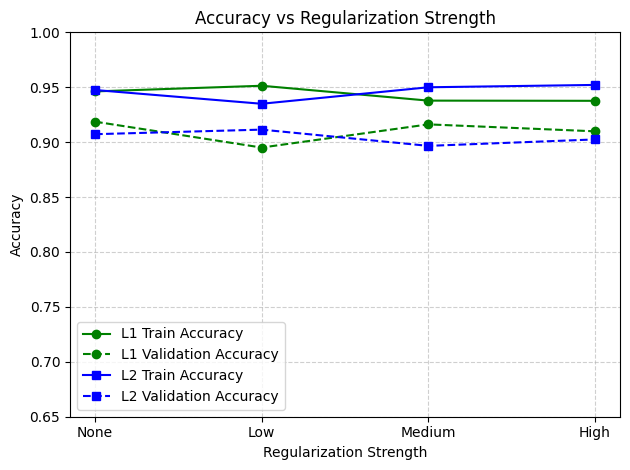

In [ ]:
# Plotting our results
# Note: L1 regularizaton is more sensitive to regularization values.
# To achieve a fair comparison, we scaled the regularization factors down by a factor of 10 for L1.

regularization_levels = ["None", "Low", "Medium", "High"]

# L1 Regularization
plt.plot(regularization_levels, l1_train_accuracies_3, label='L1 Train Accuracy', color="green",marker='o', linestyle='-')
plt.plot(regularization_levels, l1_val_accuracies_3, label='L1 Validation Accuracy', color="green",marker='o', linestyle='--')

# L2 Regularization
plt.plot(regularization_levels, l2_train_accuracies_3, label='L2 Train Accuracy', color="blue",marker='s', linestyle='-')
plt.plot(regularization_levels, l2_val_accuracies_3, label='L2 Validation Accuracy', color="blue", marker='s', linestyle='--')

# Labels and legend
plt.title("Accuracy vs Regularization Strength")
plt.xlabel("Regularization Strength")
plt.ylabel("Accuracy")
plt.ylim(0.65, 1)  # Adjust based on data range
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

**Analysis**

We observe very similar performance on both train and test sets, even with varying L1 and L2 regularization values. However, there is some evidence of a slight performance increase on the validation set, proportional to the amount of regularization.

This similar performance can be explained by multiple factors:
- **Underlying structure of our model:** Our MLP model already has a large amount of trainable parameters, given the large amounts of hidden units. This means the model can already fit the data's underlying distribution easily, resulting in low effects from regularization.
- **Dataset Size:** We are already training on a relatively large dataset -- The optimizer we are using makes 1000 iterations on batches of size 64, meaning that it is already influenced by a large part of our train set (of size > 30 000). Since a higher dataset size already leads to better generalization capabilities, the model is already able to generalize well on the validation set.


#### **3.4 - Data Normalization Comparison**

In this subsection, we will be using our same MLP model with 2 hidden layers each, having 256 units with ReLU activations as seen in previous subsections. However, this time, we will be training the model with unnormalized images, and comparing its performance to the model trained on normalized images.



First, we must acquire our unnormalized data:

In [ ]:
#get rid of the normalization within the transformations so the images won't be normalized

# Define preprocessing transformations
transformations = transforms.Compose([
    transforms.ToTensor(),
    #normalization removed !
    ])

#get new train and test data without the normalization transformation for this task (task 4)
train_dataset_4 = CustomOrganAMNIST(split="train", transform = transformations, download=True)
val_dataset_4 = CustomOrganAMNIST(split="val", transform=transformations, download=True)

print("\nTrain Dataset:\n")
print(train_dataset_4)
print("\n------------------------------------------------------\n")
print("Validation Dataset:\n")
print(val_dataset_4)

print("\nDataset types:", type(train_dataset_4), type(val_dataset_4))

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz

Train Dataset:

Dataset CustomOrganAMNIST of size 28 (organamnist)
    Number of datapoints: 34561
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34561, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdomi

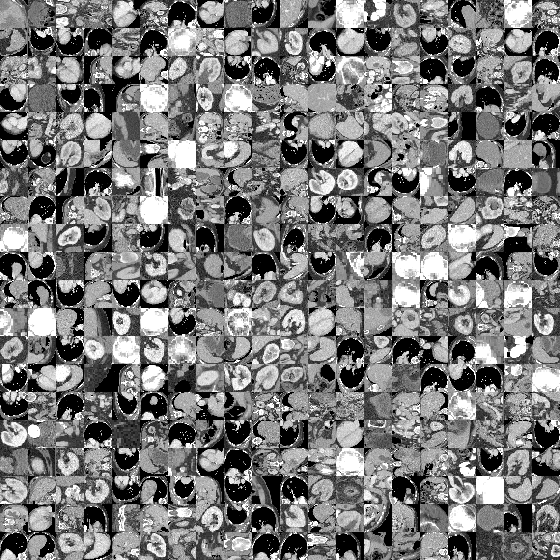

In [ ]:
# We can now illustrate some elements of our dataset (but without normalization)
train_dataset_4.montage(length=20)

In [ ]:
#we can extract our x and y datasets from the new datasets
train_loader_4 = DataLoader(train_dataset_4, batch_size=len(train_dataset_4), shuffle=False)

x4, y4 = None, None

for x4_elems, y4_elems in train_loader_4:
  x4 = x_elems
  y4 = y_elems

print(x4.shape) # N x D
print(y4.shape) # N x output_dim

print("Converting to NumPy arrays...")
x4 = x4.detach().numpy()
y4 = y4.detach().numpy()
print(x4.shape)
print(y4.shape)

torch.Size([6491, 784])
torch.Size([6491, 11])
Converting to NumPy arrays...
(6491, 784)
(6491, 11)


In [ ]:
# Next, we can extract our test x_test and y_test datasets for the new datasets
test_loader_4 = DataLoader(val_dataset_4, batch_size=len(val_dataset_4), shuffle=False)

x4_val, y4_val = None, None

for x4_elems, y4_elems in test_loader_4:
  x4_val = x4_elems
  y4_val = y4_elems

print(x4_val.shape) # N x D
print(y4_val.shape) # N x output_dim

print("Converting to NumPy arrays...")
x4_val = x4_val.detach().numpy()
y4_val = y4_val.detach().numpy()
print(x4_val.shape)
print(y4_val.shape)

torch.Size([6491, 784])
torch.Size([6491, 11])
Converting to NumPy arrays...
(6491, 784)
(6491, 11)


In [ ]:
#same 2 layer with 256 units and relu activation model
relu_model_4 = ClassificationMLP(
    activation = relu, # relu activation
    activation_derivative = relu_derivative,
    is_verbose = False,
    M = [256, 256], # 2 hidden layers
    output_dim = 11
)

In [ ]:
low_iter_train_accuracies_4 = []
low_iter_val_accuracies_4 = []


train_and_eval_classification(relu_model_4, optimizer_low_iter, x4, y4, x4_val, y4_val, low_iter_train_accuracies_4, low_iter_val_accuracies_4)

print("Train accuracy (unnormalized images):", low_iter_train_accuracies_4)
print("Validation accuracy (unnormalized images):", low_iter_val_accuracies_4)

Train accuracy (unnormalized images): [1.0]
Validation accuracy (unnormalized images): [0.2081343398551841]


In [ ]:
mid_iter_train_accuracies_4 = []
mid_iter_val_accuracies_4 = []


train_and_eval_classification(relu_model_4, optimizer_mid_iter, x4, y4, x4_val, y4_val, mid_iter_train_accuracies_4, mid_iter_val_accuracies_4)

print("Train accuracy (unnormalized images):", mid_iter_train_accuracies_4)
print("Validation accuracy (unnormalized images):", mid_iter_val_accuracies_4)

Train accuracy (unnormalized images): [1.0]
Validation accuracy (unnormalized images): [0.21737790787243877]


In [ ]:
high_iter_train_accuracies_4 = []
high_iter_val_accuracies_4 = []


train_and_eval_classification(relu_model_4, optimizer_high_iter, x4, y4, x4_val, y4_val, high_iter_train_accuracies_4, high_iter_val_accuracies_4)

print("Train accuracy (unnormalized images):", high_iter_train_accuracies_4)
print("Validation accuracy (unnormalized images):", high_iter_val_accuracies_4)

Train accuracy (unnormalized images): [1.0]
Validation accuracy (unnormalized images): [0.19488522569711908]


In [ ]:
very_high_iter_train_accuracies_4 = []
very_high_iter_val_accuracies_4 = []


train_and_eval_classification(relu_model_4, optimizer_very_high_iter, x4, y4, x4_val, y4_val, very_high_iter_train_accuracies_4, very_high_iter_val_accuracies_4)

print("Train accuracy (unnormalized images):", very_high_iter_train_accuracies_4)
print("Test accuracy (unnormalized images):", very_high_iter_val_accuracies_4)

Train accuracy (unnormalized images): [1.0]
Test accuracy (unnormalized images): [0.21660761053766753]


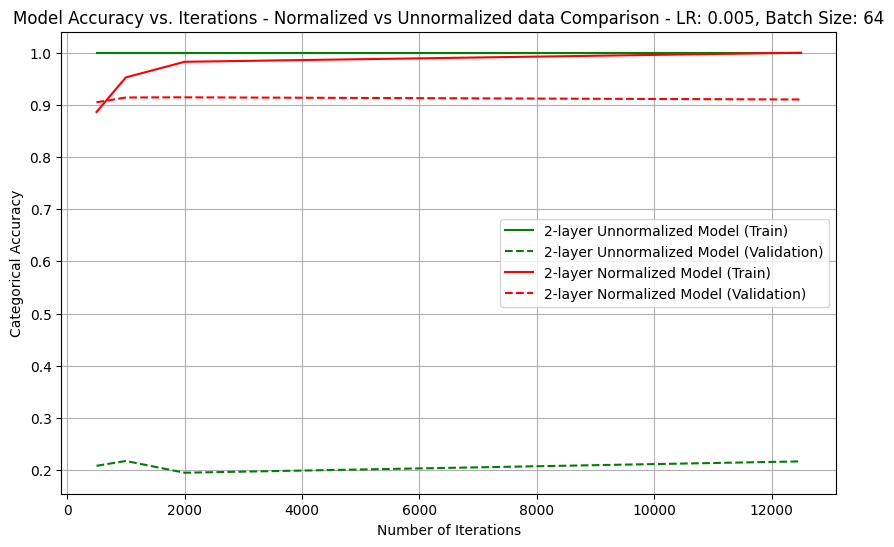

In [ ]:
train_accuracies_4 = [
    low_iter_train_accuracies_4,
    mid_iter_train_accuracies_4,
    high_iter_train_accuracies_4,
    very_high_iter_train_accuracies_4
]
val_accuracies_4 = [
    low_iter_val_accuracies_4,
    mid_iter_val_accuracies_4,
    high_iter_val_accuracies_4,
    very_high_iter_val_accuracies_4
]

unnorm_model_train_accuracies_4 = [accs[0] for accs in train_accuracies_4]
unnorm_model_val_accuracies_4 = [accs[0] for accs in val_accuracies_4]

# Plotting
plt.figure(figsize=(10, 6))

iterations = [500, 1000, 2000, 12500]

# unnormalized model
plt.plot(iterations, unnorm_model_train_accuracies_4, label='2-layer Unnormalized Model (Train)', color='green', linestyle='-')
plt.plot(iterations, unnorm_model_val_accuracies_4, label='2-layer Unnormalized Model (Validation)', color='green', linestyle='--')

# Two-layer model (from 3.1 to compare the unnormalized to)
plt.plot(iterations, two_layer_model_train_accuracies, label='2-layer Normalized Model (Train)', color='red', linestyle='-')
plt.plot(iterations, two_layer_model_val_accuracies, label='2-layer Normalized Model (Validation)', color='red', linestyle='--')

# Labels and legend
plt.xlabel("Number of Iterations")
plt.ylabel("Categorical Accuracy")
plt.title("Model Accuracy vs. Iterations - Normalized vs Unnormalized data Comparison - LR: 0.005, Batch Size: 64")
plt.legend(loc="best")
plt.grid(True)

plt.show()

**Analysis**

- Normalized data performs significanly better on validation set: This is because normalization leads to gradient stability, ensuring gradient updates are more stable, as well as the unnormalized model overfitting as per the point below.

- Unnormalized data has consistently high train accuracy: This is due to the fact that unnormalized features could exxagerate the separability of classes in the training dataset and exploit dominant features in the data.

#### **3.5 - High Resolution Data Comparison**

In this subsection, we will be retraining the MLP model from subsection 3.3, MLP with 2 hidden layers each having 256 units with ReLU activations, but this time with the 128x128 resolution images from OrganAMNIST with normalization, instead of the 28x28 version. We will analyze how this effects the model's accuracy and training time (in terms of epochs and compute time).

**First, we must load the 128x128 images and normalize the data:**

In [ ]:
print("Using MedMNIST version:", medmnist.__version__, "\n")

# Load datasets using custom image and data encoding
val_dataset_28 = CustomOrganAMNIST(split="val", transform = transformations, download=True)
train_dataset_128 = CustomOrganAMNIST(split="train", transform = transformations, download=True, size=128)
val_dataset_128 = CustomOrganAMNIST(split="val", transform = transformations, download=True, size=128)

print("\nTrain Dataset:\n")
print(train_dataset_128)
print("\n------------------------------------------------------\n")
print("Validation Dataset:\n")
print(val_dataset_128)

print("\nDataset types:", type(train_dataset_128), type(val_dataset_128))

# Load Data in batches:
batch_size = 256
train_loader_128 = DataLoader(train_dataset_128, batch_size=batch_size, shuffle=True)
val_loader_128 = DataLoader(val_dataset_128, batch_size=batch_size, shuffle=False)


Using MedMNIST version: 3.0.2 

Using downloaded and verified file: /root/.medmnist/organamnist.npz


100%|██████████| 708M/708M [00:24<00:00, 28.6MB/s]


Using downloaded and verified file: /root/.medmnist/organamnist_128.npz

Train Dataset:

Dataset CustomOrganAMNIST of size 128 (organamnist_128)
    Number of datapoints: 34561
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34561, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the

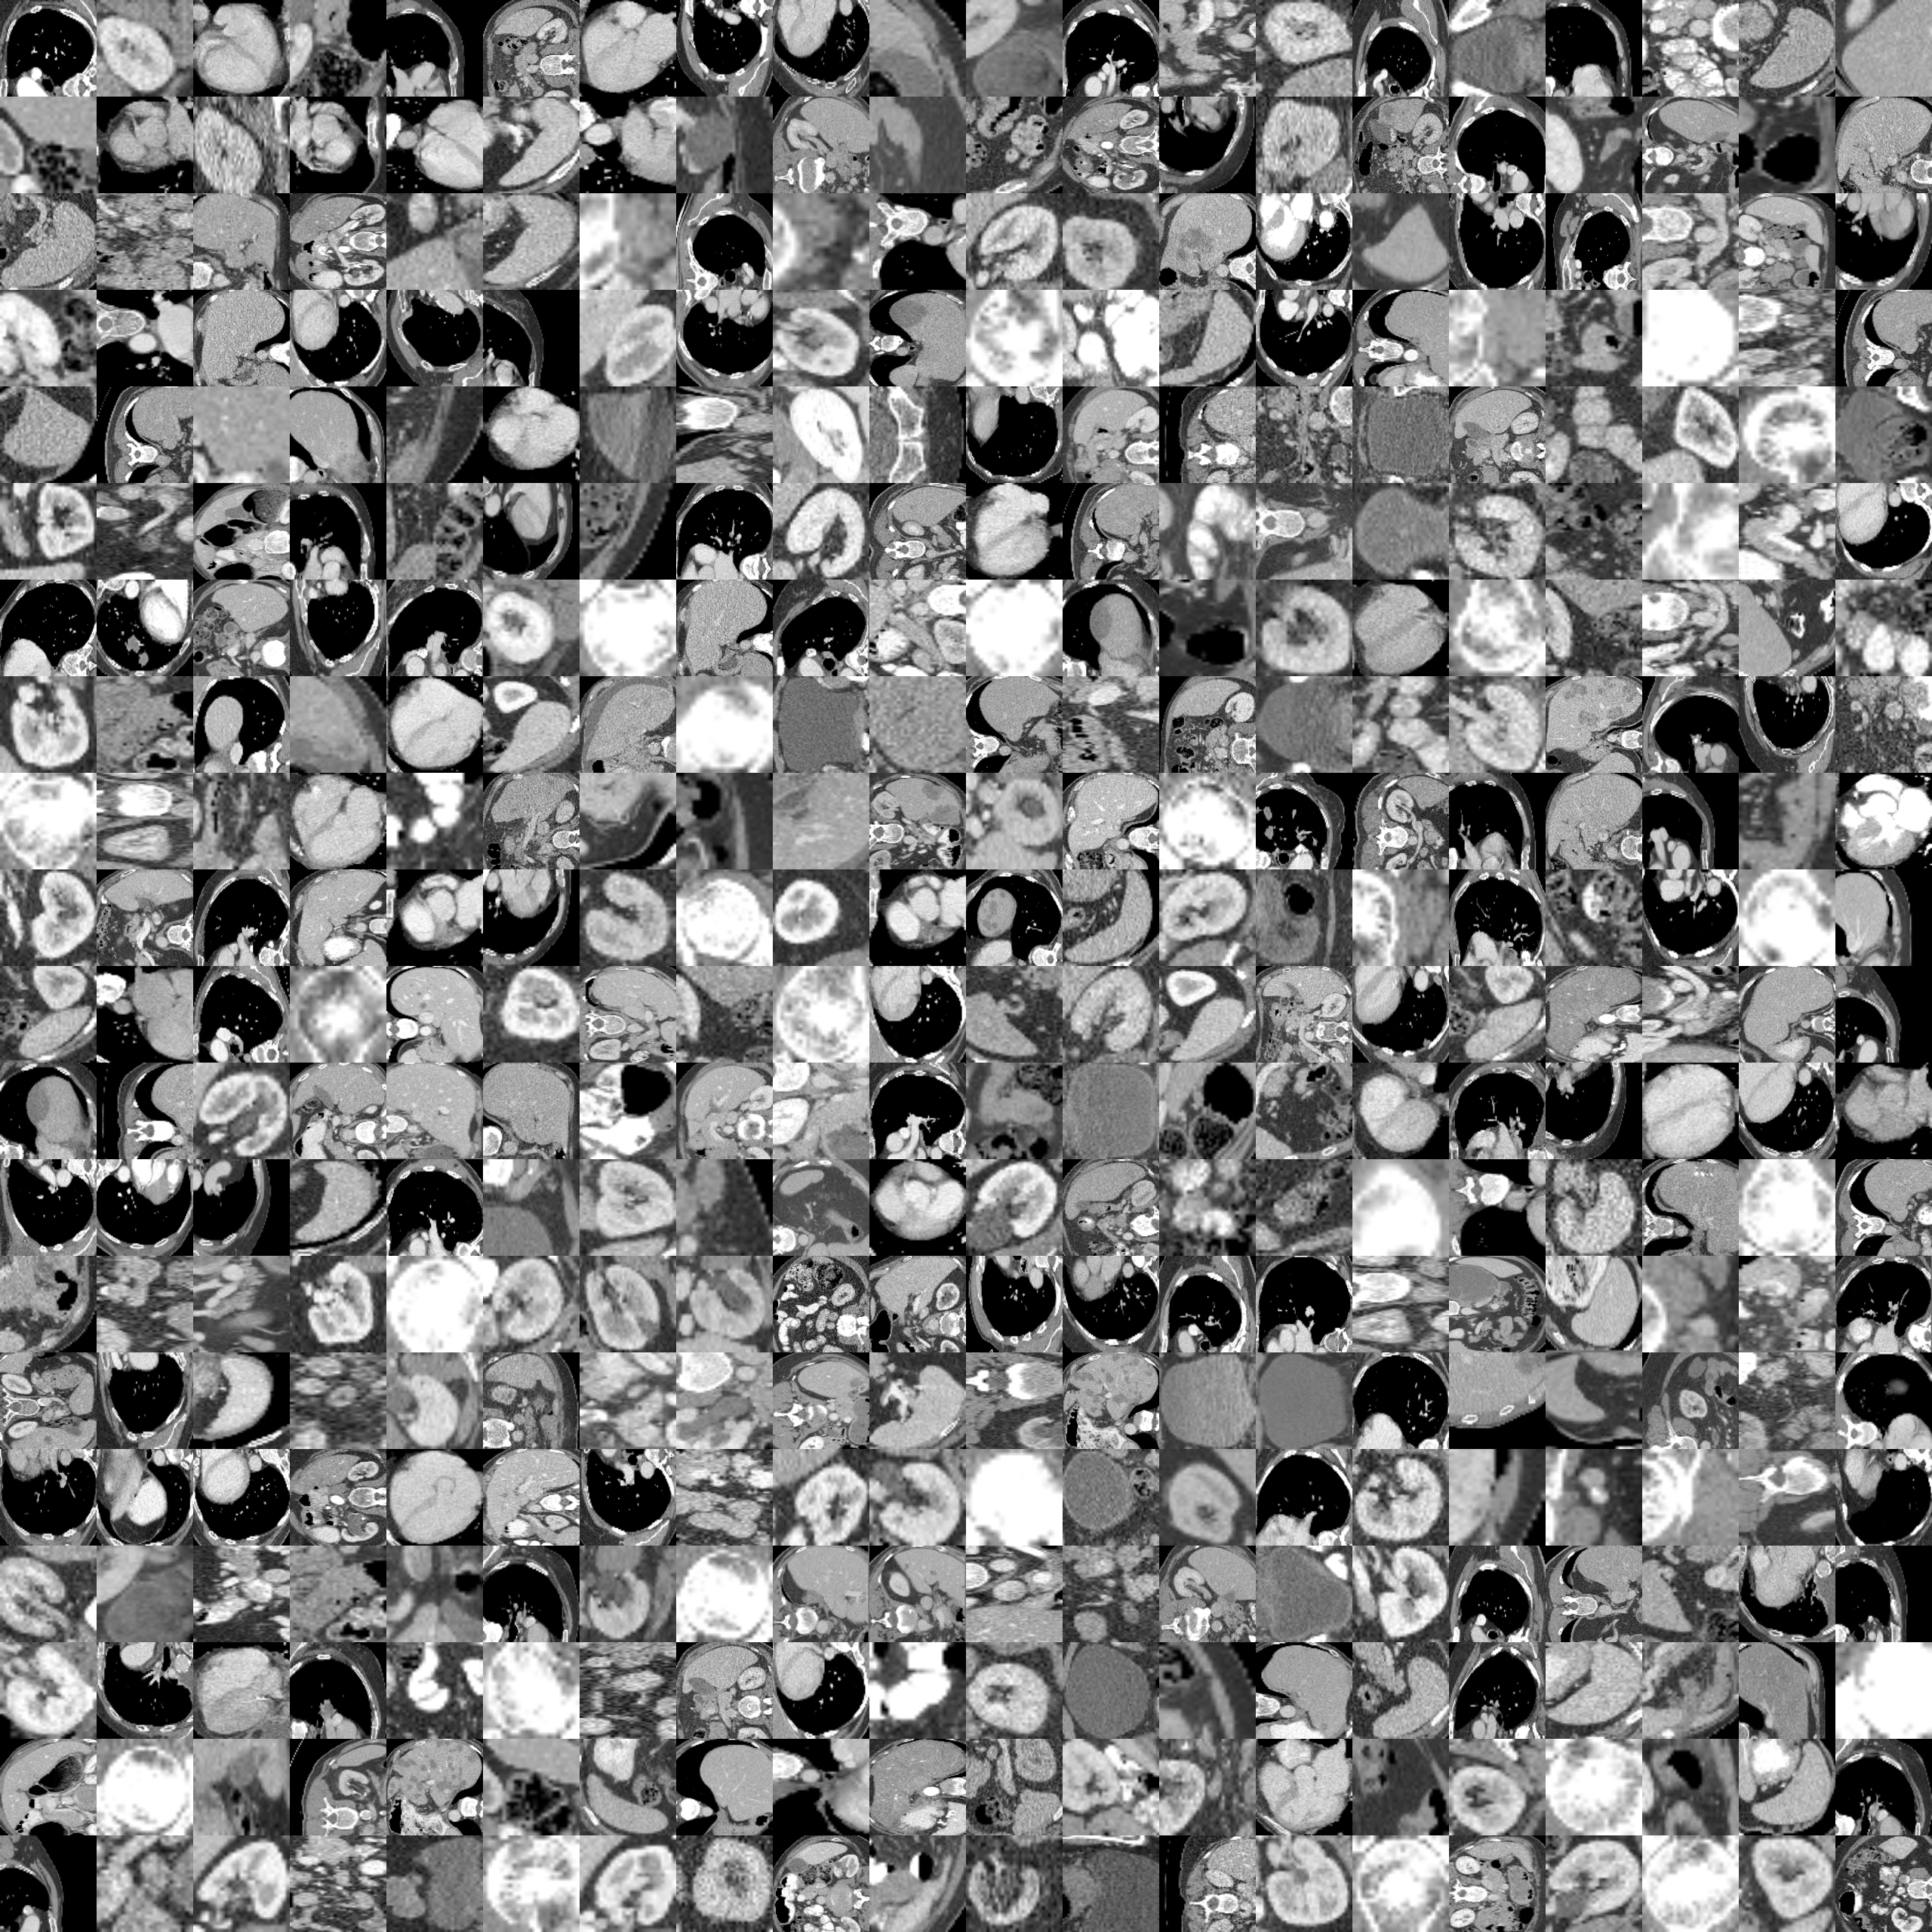

In [ ]:
train_dataset_128.montage(length=20)

**Next, we will retrain our model on the 28x28 image data, so that we can compare its performance relative to that of the 128x128 image data:**

In [ ]:
def load_full_28_dataset():

  # First, we can extract our x and y datasets.
  train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

  x, y = None, None

  for x_elems, y_elems in train_loader:
    x = x_elems
    y = y_elems

  print(x.shape) # N x D
  print(y.shape) # N x output_dim

  print("Converting to NumPy arrays...")
  x = x.detach().numpy()
  y = y.detach().numpy()
  print(x.shape)
  print(y.shape)


  # Next, we can extract our test x_test and y_test datasets.

  val_loader = DataLoader(val_dataset_28, batch_size=len(val_dataset_28), shuffle=False)

  x_val, y_val = None, None

  for x_elems, y_elems in val_loader:
    x_val = x_elems
    y_val = y_elems

  print(x_val.shape) # N x D
  print(y_val.shape) # N x output_dim

  print("Converting to NumPy arrays...")
  x_val = x_val.detach().numpy()
  y_val = y_val.detach().numpy()
  print(x_val.shape)
  print(y_val.shape)

  return x, y, x_val, y_val

x, y, x_val, y_val = load_full_28_dataset()

max_iters_28 = [5, 20, 50, 100, 500, 1000, 2000]
batch_size_28 = 64
training_times_28 = []
epochs_28 = []
train_accs_28 = []
val_accs_28 = []
trained_models_28 = []

print("\nResults for 28x28 Image Dataset:")
for max_iter in max_iters_28:
  # Create Model:
  model_28 = ClassificationMLP(
    activation = relu,
    activation_derivative = relu_derivative,
    is_verbose = False,
    M = [256, 256], # No hidden layers
    output_dim = 11)

  optimizer1 = GradientDescent(learning_rate = 0.005, max_iters = max_iter, epsilon=1e-9, batch_size=batch_size_28)


  # Train and run Model:
  start_time = time.time()
  trained_model_28 = model_28.fit(x, y, optimizer1)
  end_time = time.time()
  elapsed_time_28 = end_time - start_time
  trained_models_28.append(trained_model_28)
  train_acc_28 = ClassificationMLP.evaluate_acc(y, trained_model_28.predict(x))
  val_acc_28 = ClassificationMLP.evaluate_acc(y_val, trained_model_28.predict(x_val))
  iters_28 = optimizer1.iters
  epoch_28 = math.ceil((iters_28 * batch_size_28)/len(train_dataset))

  # Save results:
  training_times_28.append(elapsed_time_28)
  train_accs_28.append(train_acc_28)
  val_accs_28.append((val_acc_28))
  epochs_28.append(int(epoch_28))

  # Print Results:
  print(f"\nWith {max_iter} max iterations:")
  print(f"\tTraining Time: {elapsed_time_28:.2f}s")
  print("\tIterations:", iters_28)
  print(f"\tEpochs: {epoch_28}")
  print(f"\tTraining Set Accuracy: {(train_acc_28*100):.2f}%")
  print(f"\tValidation Set Accuracy: {(val_acc_28*100):.2f}%")


torch.Size([34561, 784])
torch.Size([34561, 11])
Converting to NumPy arrays...
(34561, 784)
(34561, 11)
torch.Size([6491, 784])
torch.Size([6491, 11])
Converting to NumPy arrays...
(6491, 784)
(6491, 11)

Results for 28x28 Image Dataset:

With 5 max iterations:
	Training Time: 0.11s
	Iterations: 5
	Epochs: 0.01
	Training Set Accuracy: 17.84%
	Validation Set Accuracy: 15.91%

With 20 max iterations:
	Training Time: 0.24s
	Iterations: 20
	Epochs: 0.04
	Training Set Accuracy: 27.99%
	Validation Set Accuracy: 15.91%

With 50 max iterations:
	Training Time: 0.45s
	Iterations: 50
	Epochs: 0.09
	Training Set Accuracy: 41.22%
	Validation Set Accuracy: 30.24%

With 100 max iterations:
	Training Time: 0.84s
	Iterations: 100
	Epochs: 0.19
	Training Set Accuracy: 63.92%
	Validation Set Accuracy: 13.85%

With 500 max iterations:
	Training Time: 5.48s
	Iterations: 500
	Epochs: 0.93
	Training Set Accuracy: 87.92%
	Validation Set Accuracy: 16.01%

With 1000 max iterations:
	Training Time: 7.49s
	Itera

**Now, to train our model on the higher resolution images.**

It is important to note that as these higher resolution images are so much larger, the input matrix also becomes much larger: each instance now has 16,384 features (128 x 128), so we must use PyTorch's dataloader to fit the model in batches.

In [ ]:
### For testing purposes, change list of max_iters to [2,3,4]


def batch_train(model, optimizer, max_iter, train_dataset, batch_size, verbose=False):
  # Load Data in batches:
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  iters_128 = 0
  train_time = 0

  st_time = time.time()
  for iter in range(max_iter):

    b = 0                                         #batch num
    x_batch = y_batch = None

    # Iterate over the DataLoader (ie in batches)
    for xs, ys in train_loader:

      x_batch = xs
      y_batch = ys
      x_batch = x_batch.view(x_batch.size(0), -1) # Drop num of channels

      if (b<1 and iter == 0 and verbose):
        print("Training Set:")
        print(x_batch.shape)                      # N x D (128, 16384)
        print(y_batch.shape)                      # N x C (128, 11)
        print("Converting to NumPy arrays...")

      x_batch = x_batch.detach().numpy()
      y_batch = y_batch.detach().numpy()

      if (b<1 and iter == 0 and verbose):
        print(x_batch.shape)
        print(y_batch.shape)

      # Train model on cur batch
      start_time = time.time()
      model = model.fit_batch(x_batch, y_batch, optimizer, b)

      # Calculate the time taken
      end_time = time.time()
      elapsed_time = end_time - start_time

      # Update Vars for next iter
      train_time += elapsed_time
      b = 1

    # End of current batch
    iters_128 += 1
    if np.any(optimizer.norms < optimizer.epsilon):
      print("Reached convergence. Stopped.")
      break


  e_time = time.time()
  ttl_time = e_time - st_time
  return model, iters_128, ttl_time, train_time



#max_iters_128 = [10, 20, 50]   # 3, 6, 30 minutes
# Epochs:
max_iters_128 = [2, 3, 5, 10] #50]  # to test functionality (takes 3min)
batch_size = 2048

trained_models_128 = []
iters_list_128 = []
run_times_128 = []
train_times_128 = []
verbose = True

for i, max_iter in enumerate(max_iters_128):
  # Now, we can create our model:
  model_128 = ClassificationMLP(
      activation = relu,
      activation_derivative = relu_derivative,
      is_verbose = False,
      M = [256, 256],
      output_dim = 11)

  optimizer_128 = GradientDescent(learning_rate = 0.001, max_iters = 1, epsilon=1e-9, batch_size=64)


  # Train model
  trained_model_128, iters_128, run_time_128, train_time_128 = batch_train(model_128, optimizer_128, max_iter, train_dataset_128, batch_size, verbose=verbose)

  # Save results
  trained_models_128.append(trained_model_128)
  iters_list_128.append(iters_128)
  run_times_128.append(run_time_128)
  train_times_128.append(train_time_128)

  # Output:
  print(f"\n\nTraining using {max_iter} iterations:")
  print(f"Training Time: {run_time_128:.2f}s, Actual time fitting: {train_time_128:.2f}s")
  print(f"Iterations: {iters_128}")
  verbose = False

Training Set:
torch.Size([2048, 16384])
torch.Size([2048, 11])
Converting to NumPy arrays...
(2048, 16384)
(2048, 11)


Training using 2 iterations:
Training Time: 28.95s, Actual time fitting: 7.81s
Iterations: 2


Training using 3 iterations:
Training Time: 42.58s, Actual time fitting: 11.50s
Iterations: 3


Training using 5 iterations:
Training Time: 71.45s, Actual time fitting: 18.93s
Iterations: 5


Training using 10 iterations:
Training Time: 141.07s, Actual time fitting: 37.75s
Iterations: 10


**Testing and Reporting Performance Metrics:**

In [ ]:
# Extract x_train, y_train:
#print("Training Set:")
x_train_list = []     #list of all x_batches
y_train_list = []     #list of all y_batches

# Iterate over the DataLoader and collect all data
c = 0
x_batch = y_batch = None
for xs, ys in train_loader_128:
    x_batch = xs
    y_batch = ys

    x_batch = x_batch.view(x_batch.size(0), -1) # Drop num of channels
    x_batch = x_batch.detach().numpy()
    y_batch = y_batch.detach().numpy()

    x_train_list.append(x_batch)
    y_train_list.append(y_batch)
    c += 1

# Next, extract Validation Sets:
x_val_list = []
y_val_list = []

# Iterate over the DataLoader and collect all data
c = 0
x_batch = y_batch = None
for xs, ys in val_loader_128:
    x_batch = xs
    y_batch = ys

    x_batch = x_batch.view(x_batch.size(0), -1) # Drop num of channels

    x_batch = x_batch.detach().numpy()
    y_batch = y_batch.detach().numpy()

    x_val_list.append(x_batch)
    y_val_list.append(y_batch)
    c += 1

def batch_eval(model):
  # Predict in batches
  yh_train_list = []
  yh_val_list = []

  # Collect predictions for the training data
  for x_train_batch in x_train_list:
    yh_train_list.append(model.predict(x_train_batch))

  # Collect predictions for the val data
  for x_val_batch in x_val_list:
    yh_val_list.append(model.predict(x_val_batch))

  # Concatenate the predictions into a single array
  x_train = np.concatenate(x_train_list, axis=0)
  y_train = np.concatenate(y_train_list, axis=0)

  x_val = np.concatenate(x_val_list, axis=0)
  y_val = np.concatenate(y_val_list, axis=0)

  yh_train = np.concatenate(yh_train_list, axis=0)
  yh_val = np.concatenate(yh_val_list, axis=0)

  # Evaluate Accuracy
  train_acc = ClassificationMLP.evaluate_acc(y_train, yh_train)
  val_acc = ClassificationMLP.evaluate_acc(y_val, yh_val)


  return train_acc, val_acc


train_accs_128 = []
val_accs_128 = []
print("\nResults for 128x128 Image Dataset:")

for i, max_iter in enumerate(max_iters_128):
  train_acc_128, val_acc_128 = batch_eval(trained_models_128[i])
  train_accs_128.append(train_acc_128)
  val_accs_128.append(val_acc_128)

  print(f"\nWith {max_iter} iterations:")
  print(f"\tTraining Times: {run_times_128[i]:.2f}s, {train_times_128[i]:.2f}s")
  print(f"\tIterations: {iters_list_128[i]}")
  print(f"\tTraining Set Accuracy: {(train_acc_128*100):.2f}%")
  print(f"\tValidation Set Accuracy: {(val_acc_128*100):.2f}%")



Results for 128x128 Image Dataset:

With 2 iterations:
	Training Times: 28.95s, 7.81s
	Iterations: 2
	Training Set Accuracy: 17.84%
	Validation Set Accuracy: 15.91%

With 3 iterations:
	Training Times: 42.58s, 11.50s
	Iterations: 3
	Training Set Accuracy: 17.84%
	Validation Set Accuracy: 15.91%

With 5 iterations:
	Training Times: 71.45s, 18.93s
	Iterations: 5
	Training Set Accuracy: 17.84%
	Validation Set Accuracy: 15.91%

With 10 iterations:
	Training Times: 141.07s, 37.75s
	Iterations: 10
	Training Set Accuracy: 17.84%
	Validation Set Accuracy: 15.91%


**Plotting Results:**

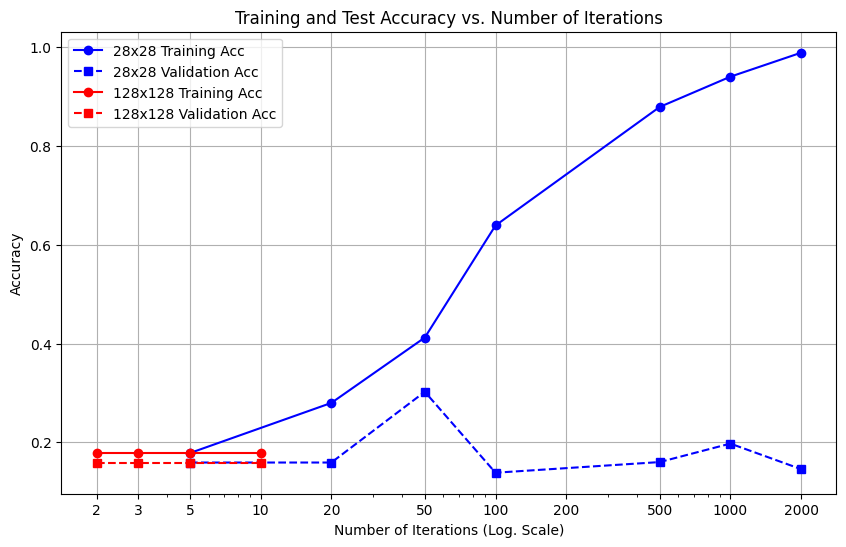

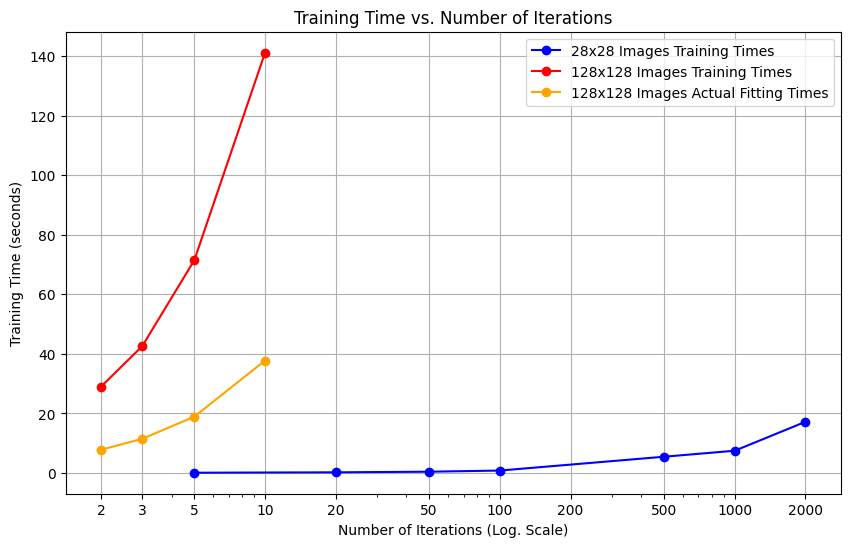

In [ ]:
# Plot Accuracies vs. Number of Epochs
plt.figure(figsize=(10, 6))

# 28x28 Images
plt.plot(epochs_28, train_accs_28, marker='o', linestyle='-', color='blue', label='28x28 Training Acc')
plt.plot(epochs_28, val_accs_28, marker='s', linestyle='--', color='blue', label='28x28 Validation Acc')

# 128x128 Images
plt.plot(max_iters_128, train_accs_128, marker='o', linestyle='-', color='red', label='128x128 Training Acc')
plt.plot(max_iters_128, val_accs_128, marker='s', linestyle='--', color='red', label='128x128 Validation Acc')

# Format x-axis
'''plt.xscale('log')
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks([2, 3, 5, 10, 20, 50, 100, 200, 500, 1000, 2000])'''

# Show
plt.title('Training and Test Accuracy vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



# Plot Training Time vs. Number of Epochs
plt.figure(figsize=(10, 6))

# 28x28
plt.plot(max_iters_28, training_times_28, marker='o', linestyle='-', color='blue', label='28x28 Images Training Times')

# 128x128
plt.plot(max_iters_128, run_times_128, marker='o', linestyle='-', color='red', label='128x128 Images Training Times')
plt.plot(max_iters_128, train_times_128, marker='o', linestyle='-', color='orange', label='128x128 Images Actual Fitting Times')

# Format x-axis
plt.xscale('log')
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks([2,3,5, 10, 20, 50, 100, 200, 500, 1000, 2000])

# Show
plt.title('Training Time vs. Number of Iterations')
plt.xlabel('Number of Iterations (Log. Scale)')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

**Analysis of the Performance of our MLP model on 28x28 image size data vs. 128x128**

  * **Effect on Model Accuracy:** The MLP achieves high training and validation accuracy on 28x28 images, steadily improving with iterations (specifically around 1000 iterations). On 128x128 images, accuracy is significantly lower and unstable, indicating the MLP struggles to learn from higher-dimensional data.

  * **Effect on Training Time:** Training on 28x28 images is efficient, with minimal time increase even for many epochs. In contrast, training on 128x128 images is much slower, with training time increasing sharply due to the exponential growth in parameters.


This is to be expected as the model now has over 16,384 parameters to learn (128x128) as opposed to 784 (28x28). Looking at the orange line, we see that the time the model spends actually fitting the parameters is much lower, but due to the need to load the data in batches, the training time increases drastically.

#### **3.6 - CNN Model**

**Define our CNN Model using PyTorch Library:**

In [ ]:
# Define our CNN model:

class OrganCNN(nn.Module):

  def __init__(self, kernel_size, image_size, units_per_layer):
    super().__init__()

    # Define each Convolution, based off the LeNet-5 Architecture (out channels for image data: 6 for first, 16 for second)
    self.conv1 = nn.Conv2d(1, 6, kernel_size)                 #first conv layer (in_channels, out_channels, kernel_size)
    self.conv2 = nn.Conv2d(6, 16, kernel_size)                #second conv layer (in matches layer1's out, 5x5 kernel again) test out various values

    # Compute outputs sizes
    output_size_conv1 = image_size - kernel_size + 1          #output = input_size - kernel_size + 1
    output_size_conv2 = output_size_conv1 - kernel_size + 1

    # Define Fully Connected Layers:
    self.num_features_fc1 = 16 * output_size_conv2 * output_size_conv2
    self.fc1 = nn.Linear(self.num_features_fc1, units_per_layer)  #256 units in layer
    self.fc2 = nn.Linear(units_per_layer, 11)                 #11 classes to predict


  def forward(self, x):
    x = F.relu(self.conv1(x))               #apply Relu(first_conv(x))
    x = F.relu(self.conv2(x))
    x = x.view(-1, self.num_features_fc1)   #Flatten feature map
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


# Custom dataset class to apply one-hot encoding to labels, but this time does NOT flatten image to [784], keeps as [1, 28, 28]
class CustomOrganAMNIST2(OrganAMNIST):

  def __getitem__(self, index):
    # Get the original image and target label
    image, target = super().__getitem__(index)

    # Check if there are null values in the dataset
    if torch.isnan(image).any():
      raise ValueError(f"NaN values found in image at index {index}")

    # Convert target label to one-hot encoding
    target = to_one_hot(target, num_classes=11)

    return image, target


# Define Model Training Function:
def train_cnn(train_loader, kernel_size=3, image_size=28, units_per_layer=256, lr=0.005, num_epochs=20):
  model = OrganCNN(kernel_size=kernel_size, image_size=image_size, units_per_layer=units_per_layer)

  # Define loss function and optimizer:
  criterion = nn.CrossEntropyLoss()
  cnn_optimizer = optim.SGD(model.parameters(), lr=lr)

  # Move to GPUs:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # Train Model:
  model.train()   #set model to training model

  start_time = time.time()
  for epoch in range(num_epochs):
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Convert one-hot encoded labels to class indices (PyTorch expects C in 0,...,11)
      labels = torch.argmax(labels, dim=1)

      # Zero the parameter gradients
      cnn_optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      loss.backward()
      cnn_optimizer.step()
  end_time = time.time()

  return model, (end_time - start_time)    #return training time


def evaluate_cnn(model, data_loader):
  # Move to GPUs:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  model.eval()  # Set model to evaluation mode
  correct_preds = 0
  total = 0

  with torch.no_grad():  #skip gradient computations
      for inputs, labels in data_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          labels = torch.argmax(labels, dim=1)

          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct_preds += (predicted == labels).sum().item()

  accuracy = 100 * correct_preds / total
  return accuracy

**Reload and format our datasets according to PyTorch configs**:

In [ ]:
# 28x28 Training Set:
train_dataset_28 = CustomOrganAMNIST2(split="train", transform=transformations, download=True)
img, label = train_dataset_28[0] # Load a sample image
print(f"Image shape: {img.shape}\n")

# 28x28 Validation Set:
val_dataset_28 = CustomOrganAMNIST2(split="val", transform=transformations, download=True)
img, label = val_dataset_28[0] # Load a sample image
print(f"Image shape: {img.shape}\n")

# 128x128 Training Set:
train_dataset_128 = CustomOrganAMNIST2(split="train", transform=transformations, download=True, size=128)
img, label = train_dataset_128[0] # Load a sample image
print(f"Image shape: {img.shape}\n")

# 128x128 Validation Set:
val_dataset_128 = CustomOrganAMNIST2(split="val", transform=transformations, download=True, size=128)
img, label = val_dataset_128[0] # Load a sample image
print(f"Image shape: {img.shape}\n")



Using downloaded and verified file: /root/.medmnist/organamnist.npz
Image shape: torch.Size([1, 28, 28])

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Image shape: torch.Size([1, 28, 28])

Using downloaded and verified file: /root/.medmnist/organamnist_128.npz
Image shape: torch.Size([1, 128, 128])

Using downloaded and verified file: /root/.medmnist/organamnist_128.npz
Image shape: torch.Size([1, 128, 128])



**Training our CNN Model:**

In [ ]:
# Set num_iters_cnn_list = [1, 2, 5, 10] ~3min

# Load Data:
train_loader_28 = DataLoader(train_dataset_28, batch_size=256, shuffle=True)

# Params:
num_iters_cnn_28 = [1, 2, 3, 5, 10] #20 TEST
#num_iters_cnn_28 = [2, 5] #20 TEST
kernel_size = 3
image_size = 28
units_per_layer = 256
lr = 0.01

trained_models_cnn_28 = []
training_times_cnn_28 = []


# Train Model:
for num_epochs in num_iters_cnn_28:
  trained_model_cnn_28, training_time_cnn_28 = train_cnn(train_loader_28, kernel_size, image_size, units_per_layer, lr, num_epochs)
  trained_models_cnn_28.append(trained_model_cnn_28)
  training_times_cnn_28.append(training_time_cnn_28)



**Evaluating CNN Model Performance:**

In [ ]:
# Load Val Data:
val_loader_28 = DataLoader(val_dataset_28, batch_size=256, shuffle=False)


train_accs_cnn_28 = []
val_accs_cnn_28 = []
for i, num_epochs in enumerate(num_iters_cnn_28):
  trained_cnn_28 = trained_models_cnn_28[i]
  training_time_cnn_28 = training_times_cnn_28[i]
  print(f"CNN Model trained on {num_epochs} iterations of the 28x28 data:" )

  #Eval Training Time:
  print(f"\tTraining Time: {training_time_cnn_28:.2f} seconds")

  # Eval on training set
  train_acc = evaluate_cnn(trained_cnn_28, train_loader_28)
  train_accs_cnn_28.append(train_acc)
  print(f'\tTraining Accuracy: {train_acc:.2f}%')

  # Eval on val set
  val_acc = evaluate_cnn(trained_cnn_28, val_loader_28)
  val_accs_cnn_28.append(val_acc)
  print(f'\tValidation Accuracy: {val_acc:.2f}%\n')



CNN Model trained on 1 iterations of the 28x28 data:
	Training Time: 30.35 seconds
	Training Accuracy: 42.26%
	Validation Accuracy: 49.51%

CNN Model trained on 2 iterations of the 28x28 data:
	Training Time: 62.31 seconds
	Training Accuracy: 17.84%
	Validation Accuracy: 15.91%

CNN Model trained on 3 iterations of the 28x28 data:
	Training Time: 96.02 seconds
	Training Accuracy: 11.96%
	Validation Accuracy: 9.74%

CNN Model trained on 5 iterations of the 28x28 data:
	Training Time: 163.61 seconds
	Training Accuracy: 52.00%
	Validation Accuracy: 63.72%

CNN Model trained on 10 iterations of the 28x28 data:
	Training Time: 325.13 seconds
	Training Accuracy: 37.59%
	Validation Accuracy: 42.26%



**Compare Performance to MLP Model:**

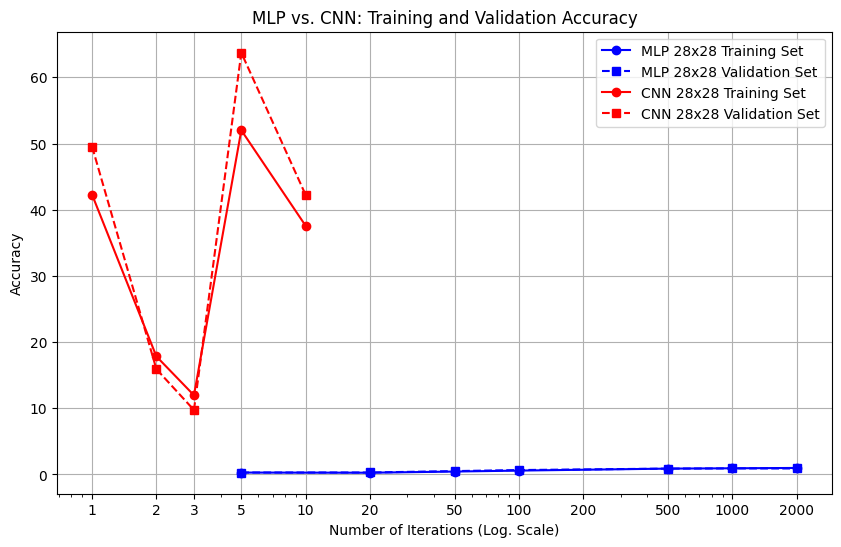

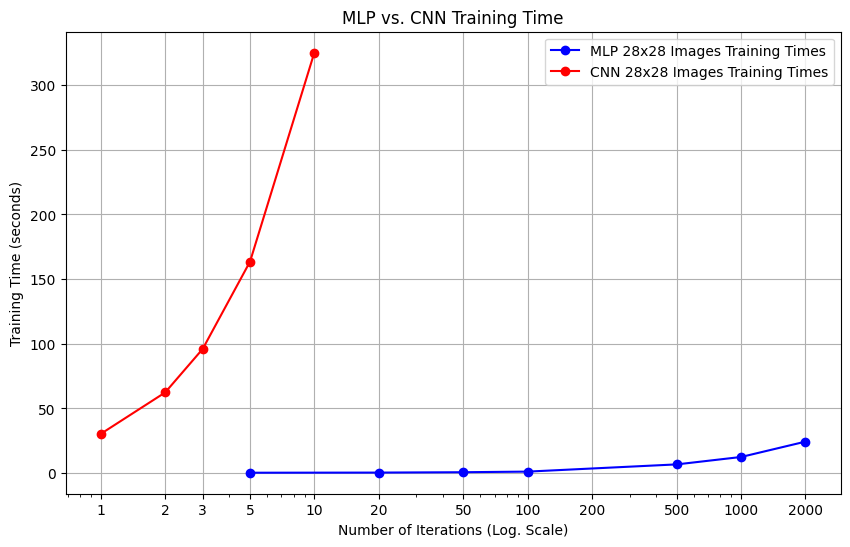

In [ ]:
# Plot Accuracies vs. Number of Epochs
plt.figure(figsize=(10, 6))

train_accs_28 = np.array(train_accs_28) * 100
val_accs_28 = np.array(val_accs_28) * 100


# MLP Model
plt.plot(epochs_28, train_accs_28, marker='o', linestyle='-', color='blue', label='MLP 28x28 Training Set')
plt.plot(epochs_28, val_accs_28, marker='s', linestyle='--', color='blue', label='MLP 28x28 Validation Set')

# CNN Model
plt.plot(num_iters_cnn_28, train_accs_cnn_28, marker='o', linestyle='-', color='red', label='CNN 28x28 Training Set')
plt.plot(num_iters_cnn_28, val_accs_cnn_28, marker='s', linestyle='--', color='red', label='CNN 28x28 Validation Set')

# Format x-axis
plt.xscale('log')
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks([1, 2, 3, 5, 10]) #, 20, 50, 100, 200, 500, 1000, 2000])

# Show
plt.title('MLP vs. CNN: Training and Validation Accuracy')
plt.xlabel('Number of Epochs (Log. Scale)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



# Plot Training Time vs. Number of Epochs
plt.figure(figsize=(10, 6))

# MLP Model
plt.plot(max_iters_28, training_times_28, marker='o', linestyle='-', color='blue', label='MLP 28x28 Images Training Times')

# CNN Model
plt.plot(num_iters_cnn_28, training_times_cnn_28, marker='o', linestyle='-', color='red', label='CNN 28x28 Images Training Times')



# Format x-axis
plt.xscale('log')
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks([1, 2, 3, 5, 10, 20, 50, 100, 200, 500, 1000, 2000])

# Show
plt.title('MLP vs. CNN Training Time')
plt.xlabel('Number of Iterations (Log. Scale)')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

**Analysis of the Performance of our MLP model on 28x28 image size data vs. PyTorch's CNN Model 28x28**

  * **Effect on Model Accuracy:**

  * **Effect on Training Time:**

#### **3.7 - Training the CNN on Higher Resolution Data**

In this subsection, we have changed our CNN model to be more effective on larger data by:
  * Adding Pooling Layers to reduce the dimensions of the feature map
  * Increasing the number of units in each hidden layer (increasing width)



In [ ]:
# Define our CNN model:

class OrganCNN128(nn.Module):

  def __init__(self, kernel_size, image_size, units_per_layer):
    super().__init__()

    # Layer 1 with pooling:
    self.conv1 = nn.Conv2d(1, 6, kernel_size)                 #first conv layer (in_channels, out_channels, kernel_size)
    self.pool1 = nn.MaxPool2d(2, 2)                            #pooling layer to reduce dimensions by half

    # Layer 2 with pooling:
    self.conv2 = nn.Conv2d(6, 16, kernel_size)                 #second conv layer (in matches layer1's out) test out various values
    self.pool2 = nn.MaxPool2d(2, 2)                            #pooling layer to reduce dimensions by half

    # Compute outputs sizes
    output_size_conv1 = (image_size - kernel_size + 1) // 2          #output = input_size - kernel_size + 1, take into account 2x2 Pooling
    output_size_conv2 = (output_size_conv1 - kernel_size + 1) // 2

    # Define Fully Connected Layers:
    self.num_features_fc1 = 16 * output_size_conv2 * output_size_conv2
    self.fc1 = nn.Linear(self.num_features_fc1, units_per_layer)  #256 units in layer
    self.fc2 = nn.Linear(units_per_layer, 11)                 #11 classes to predict


  def forward(self, x):
    # First Conv layer with pooling
    x = self.pool1(F.relu(self.conv1(x)))               #apply Relu(first_conv(x))

    # Second Conv layer with pooling
    x = self.pool2(F.relu(self.conv2(x)) )

    # Flatten features map
    x = x.view(-1, self.num_features_fc1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# Define Model Training Function:
def train_cnn_128(train_loader, kernel_size=3, image_size=128, units_per_layer=256, num_epochs=10, lr = 0.05):
  model = OrganCNN128(kernel_size=kernel_size, image_size=image_size, units_per_layer=units_per_layer)

  # Define loss function and optimizer:
  criterion = nn.CrossEntropyLoss()
  cnn_optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  # Move to GPUs:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # Train Model:
  model.train()   #set model to training model

  start_time = time.time()
  for epoch in range(num_epochs):
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Convert one-hot encoded labels to class indices (PyTorch expects C in 0,...,11)
      labels = torch.argmax(labels, dim=1)

      # Zero the parameter gradients
      cnn_optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      loss.backward()
      cnn_optimizer.step()
  end_time = time.time()

  return model, (end_time - start_time)    #return training time

**Training our model on higher resolution data:**

In [ ]:
train_loader_128 = DataLoader(train_dataset_128, batch_size=256, shuffle=True)

# Params:
num_iters_cnn_128 = [1, 2, 3, 5]

kernel_size = 3
image_size = 128
units_per_layer = 256
lr = 0.01

trained_models_cnn_128 = []
training_times_cnn_128 = []


# Train Model:
for num_epochs in num_iters_cnn_128:
  print(num_epochs)
  trained_model_cnn_128, training_time_cnn_128 = train_cnn_128(train_loader_128, kernel_size, image_size, units_per_layer, num_epochs, lr)
  trained_models_cnn_128.append(trained_model_cnn_128)
  print(training_time_cnn_128)
  training_times_cnn_128.append(training_time_cnn_128)


1
2


In [ ]:
def evaluate_cnn(model, data_loader):
  # Move to GPUs:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  model.eval()  # Set model to evaluation mode
  correct_preds = 0
  total = 0

  with torch.no_grad():  #skip gradient computations
      for inputs, labels in data_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          labels = torch.argmax(labels, dim=1)

          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct_preds += (predicted == labels).sum().item()

  accuracy = 100 * correct_preds / total
  return accuracy

# Load Val, Test Data:
val_dataset_128 = CustomOrganAMNIST2(split="val", transform=transformations, download=True, size=128)
img, label = val_dataset_128[0] # Load a sample image
print(f"Image shape: {img.shape}\n")
val_loader_128 = DataLoader(val_dataset_128, batch_size=256, shuffle=False)

#test_dataset_128 = CustomOrganAMNIST2(split="test", transform=transformations, download=True, size=128)
#test_loader_128 = DataLoader(test_dataset_128, batch_size=256, shuffle=False)


train_accs_cnn_128 = []
val_accs_cnn_128 = []
for i, num_epochs in enumerate(num_iters_cnn_128):
  trained_cnn_128 = trained_models_cnn_128[i]
  training_time_cnn_128 = training_times_cnn_128[i]
  print(f"CNN trained on {num_epochs} epochs of 128x128 Data, with SGD optimizer:" )

  #Eval Training Time:
  print(f"\tTraining Time: {training_time_cnn_128:.2f} seconds")

  # Eval on training set
  train_acc = evaluate_cnn(trained_cnn_128, train_loader_128)
  train_accs_cnn_128.append(train_acc)
  print(f'\tTraining Accuracy: {train_acc:.2f}%')

  # Eval on val set
  val_acc = evaluate_cnn(trained_cnn_128, val_loader_128)
  val_accs_cnn_128.append(val_acc)
  print(f'\tValidation Accuracy: {val_acc:.2f}%\n')



Using downloaded and verified file: /root/.medmnist/organamnist_128.npz
Image shape: torch.Size([1, 128, 128])

CNN trained on 1 epochs of 128x128 Data, with SGD optimizer:
	Training Time: 264.52 seconds
	Training Accuracy: 11.64%
	Validation Accuracy: 9.01%

CNN trained on 2 epochs of 128x128 Data, with SGD optimizer:
	Training Time: 518.11 seconds
	Training Accuracy: 10.30%
	Validation Accuracy: 7.87%



**Plotting the models:**

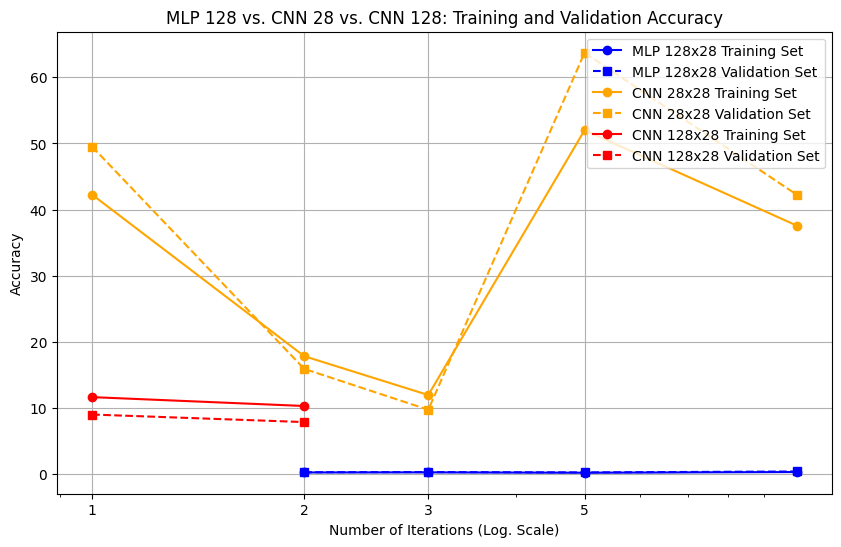

NameError: name 'training_times_128' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot Accuracies vs. Number of Epochs
plt.figure(figsize=(10, 6))

# MLP Model
train_accs_128_1 = np.array(train_accs_128) /100
val_accs_128_1 = np.array(val_accs_128)/100
print("Train Acc 128:", train_accs_128_1)
print("Val Acc 128:", val_accs_128_1)
plt.plot(max_iters_128, train_accs_128_1, marker='o', linestyle='-', color='blue', label='MLP 128x28 Training Set')
plt.plot(max_iters_128, val_accs_128_1, marker='s', linestyle='--', color='blue', label='MLP 128x28 Validation Set')

# CNN Model 28
train_accs_cnn_28_1 = np.array(train_accs_cnn_28)
val_accs_cnn_28_1 = np.array(val_accs_cnn_28)
print("Train CNN Acc 28:",train_accs_cnn_28_1)
print("Val CNN Acc 28:",val_accs_cnn_28_1)
plt.plot(num_iters_cnn_28, train_accs_cnn_28_1, marker='o', linestyle='-', color='orange', label='CNN 28x28 Training Set')
plt.plot(num_iters_cnn_28, val_accs_cnn_28_1, marker='s', linestyle='--', color='orange', label='CNN 28x28 Validation Set')

# CNN Model 128
train_accs_cnn_128_1 = np.array(train_accs_cnn_128) * 1000000
val_accs_cnn_128_1 = np.array(val_accs_cnn_128) / 100
print("Train CNN Acc 128:",train_accs_cnn_128_1)
print("Val CNN Acc 128:",val_accs_cnn_128_1)
plt.plot(num_iters_cnn_128, train_accs_cnn_128_1, marker='o', linestyle='-', color='red', label='CNN 128x28 Training Set')
plt.plot(num_iters_cnn_128, val_accs_cnn_128_1, marker='s', linestyle='--', color='red', label='CNN 128x28 Validation Set')

# Set y-axis from 0 to 100
plt.ylim(0, 100)

# Show
plt.title('MLP 128 vs. CNN 28 vs. CNN 128: Training and Validation Accuracy')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



# Plot Training Time vs. Number of Epochs
plt.figure(figsize=(10, 6))

# MLP 128 Model
plt.plot(max_iters_128, train_times_128, marker='o', linestyle='-', color='blue', label='MLP 128x128 Images Training Times')

# CNN 28 Model
plt.plot(num_iters_cnn_28, training_times_cnn_28, marker='o', linestyle='-', color='orange', label='CNN 28x28 Images Training Times')


# CNN 128 Model
plt.plot(num_iters_cnn_128, training_times_cnn_128, marker='o', linestyle='-', color='red', label='CNN 128x128 Images Training Times')



# Format x-axis
plt.xscale('log')
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks([1, 2, 3, 5, 10, 20])

# Show
plt.title('MLP 128 vs. CNN 28 vs. CNN 128: Training Time')
plt.xlabel('Number of Iterations (Log. Scale)')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

**Analysis of the Performance of our MPL model on 128x128 image size data vs. our CNN models on both datasets**

  * **Effect on Model Accuracy:**
  Another thing to note is that to reach higher accuracy level, less iterations are required with CNN for 128 size data compared to that of the 28 size data.

  * **Effect on Training Time:**



#### **3.8 - ResNet18 on our Datasets**
In this subsection, we will be loading a pretrained model, ResNet18 (courtesy of the PyTorch Library), and freezing all convolutional layers and removing the fully connected ones. This will allow us

In [ ]:
def train_resnet(train_loader, num_epochs):
  # Load pre-trained ResNet18
  resnet = models.resnet18(pretrained=True)

  ### Define Model:
    # Modify the first convolutional layer to accept 1 channel (b&w image)
  #resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)

    # Modify the first convolutional layer to accept 1 channel
  weight = resnet.conv1.weight.data
  resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)
  resnet.conv1.weight.data = weight.sum(dim=1, keepdim=True)

    # Freeze all the convolutional layers
  for param in resnet.parameters():
      param.requires_grad = False


    # Modify the fully connected layers
  num_features = resnet.fc.in_features  # Get the number of input features to the original fully connected layer
  resnet.fc = nn.Sequential(
      nn.Linear(num_features, 256),  # First fully connected layer with 256 units
      nn.ReLU(),                     # Activation function
      nn.Linear(256, 11)             # Output layer for 11 classes
  )

    # Move to GPUs
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  resnet.to(device)

    # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001)  # Only optimize the fully connected layers

  ### Train model:
  resnet.train()  # Set model to training mode

  start_time = time.time()
  for epoch in range(num_epochs):


    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      labels = torch.argmax(labels, dim=1)  # Converts one-hot encoded labels to class indices

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = resnet(inputs)
      loss = criterion(outputs, labels)
      loss.backward()  # Backpropagation
      optimizer.step()  # Optimize


  end_time = time.time()
  return resnet, (end_time - start_time)



def evaluate_resnet(model, data_loader):
  # Move to GPUs:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  model.eval()  # Set model to evaluation mode
  correct_preds = 0
  total = 0

  with torch.no_grad():  #skip gradient computations
      for inputs, labels in data_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          labels = torch.argmax(labels, dim=1)

          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct_preds += (predicted == labels).sum().item()

  accuracy = 100 * correct_preds / total
  return accuracy


**Training and Evaluating 28x28 Dataset:**

In [ ]:
### Load Data:
train_loader_28 = DataLoader(train_dataset_28, batch_size=256, shuffle=True)
val_loader_28 = DataLoader(train_dataset_28, batch_size=256, shuffle=False)


num_epochs_res_28 = [1, 2, 3, 5, 10, 16]
train_accs_res_28 = []
val_accs_res_28 = []
training_times_res_28 = []
trained_resnets_28 = []

# Iterate through num of epochs
for num_epochs in num_epochs_res_28:
  # Train Model
  trained_resnet_28, training_time_res_28 = train_resnet(train_loader_28, num_epochs)
  trained_resnets_28.append(trained_resnet_28)
  training_times_res_28.append(training_time_res_28)

  # Eval Performances
  train_acc_res_28 = evaluate_resnet(trained_resnet_28, train_loader_28)
  train_accs_res_28.append(train_acc_res_28)

  val_acc_res_28 = evaluate_resnet(trained_resnet_28, val_loader_28)
  val_accs_res_28.append(val_acc_res_28)

  # Output:
  print(f"ResNet18 trained on {num_epochs} epochs on 28x28 data, with SGD optimizer:" )
  print(f"\tTraining Time: {training_time_res_28:.2f} seconds")
  print(f'\tTraining Accuracy: {train_acc_res_28:.2f}%')
  print(f'\tValidation Accuracy: {val_acc_res_28:.2f}%\n')



**Training on 128x128 size data**

In [ ]:
### Load Data:
train_loader_128 = DataLoader(train_dataset_128, batch_size=256, shuffle=True)
val_loader_128 = DataLoader(train_dataset_128, batch_size=256, shuffle=False)


num_epochs_res_128 = [1, 2, 3, 5, 7]
train_accs_res_128 = []
val_accs_res_128 = []
training_times_res_128 = []
trained_res_128s = []

# Iterate through num of epochs
for num_epochs in num_epochs_res_128:
  # Train Model
  trained_resnet_128, training_time_res_128 = train_resnet(train_loader_128, num_epochs)
  trained_res_128s.append(trained_resnet_128)
  training_times_res_128.append(training_time_res_128)

  # Eval Performances
  train_acc_res_128 = evaluate_resnet(trained_resnet_128, train_loader_128)
  train_accs_res_128.append(train_acc_res_128)

  val_acc_res_128 = evaluate_resnet(trained_resnet_128, val_loader_128)
  val_accs_res_128.append(val_acc_res_128)

  # Output:
  print(f"ResNet18 trained on {num_epochs} epochs on 128x128 data, with SGD optimizer:" )
  print(f"\tTraining Time: {training_time_res_128:.2f} seconds")
  print(f'\tTraining Accuracy: {train_acc_res_128:.2f}%')
  print(f'\tValidation Accuracy: {val_acc_res_128:.2f}%\n')



**Plotting our results:**

In [ ]:
# Plot Accuracies vs. Number of Iterations
plt.figure(figsize=(10, 6))

# MLP Model 28x28
train_accs_28_1 = np.array(train_accs_28) / 1000
val_accs_28_1 = np.array(val_accs_28) / 1000
print("Train 28:", train_accs_28_1)
print("Val:", val_accs_28_1)
plt.plot(max_iters_28, train_accs_28_1, marker='o', linestyle='-', color='blue', label='MLP 28x28 Training Set')
plt.plot(max_iters_28, val_accs_28_1, marker='s', linestyle='--', color='blue', label='MLP 28x28 Validation Set')

# CNN Model 28x28
plt.plot(num_iters_cnn_28, train_accs_cnn_28, marker='o', linestyle='-', color='orange', label='CNN 28x28 Training Set')
plt.plot(num_iters_cnn_28, val_accs_cnn_28, marker='s', linestyle='--', color='orange', label='CNN 28x28 Validation Set')

# ResNet18 Model 28x28
plt.plot(num_epochs_res_28, train_accs_res_28, marker='o', linestyle='-', color='red', label='ResNet18 28x28 Training Set')
plt.plot(num_epochs_res_28, val_accs_res_28, marker='s', linestyle='--', color='red', label='ResNet18 28x28 Validation Set')

# Format x-axis
plt.xscale('log')
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks([1, 2, 3, 5, 10, 50, 100, 500, 1000, 2000])

# Show
plt.title('MLP 28 vs. ResNet18 28 vs. CNN 28: Training and Validation Accuracy')
plt.xlabel('Number of Iterations (Log. Scale)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



# Plot Training Time vs. Number of Epochs
plt.figure(figsize=(10, 6))

# MLP Model 28x28
plt.plot(max_iters_28, training_times_28, marker='o', linestyle='-', color='blue', label='MLP 28x28 Training Times')


# CNN Model 28x28
plt.plot(num_iters_cnn_28, training_times_cnn_28, marker='o', linestyle='-', color='orange', label='CNN 28x28 Training Times')


# ResNet18 Model 28x28
plt.plot(num_epochs_res_28, training_times_res_28, marker='o', linestyle='-', color='red', label='ResNet18 28x28 Training Times')




# Format x-axis
plt.xscale('log')
ax = plt.gca()  # Get the current axes
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='major', labelsize=10)
ax.set_xticks([1, 2, 3, 5, 10, 50, 100, 500, 1000, 2000])

# Show
plt.title('MLP 28 vs. ResNet18 28 vs. CNN 28: Training Time')
plt.xlabel('Number of Iterations (Log. Scale)')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

**Comparing our best performing models (MLP, CNN, ResNet) on the 28x28 Image Size Data::**

  * MLP

  * CNN

  * ResNet

#### **3.9 - Testing & Analysis**

In this subsection we will be doing somewhat of a conclusion to review our best models, the tradeoffs made, and the justification behind the parameters chosen. With these best models, we will test them on the testing set and you can find the results in the write-up.

**Testing MLP 28x28:**

In [ ]:
test_dataset_28 = CustomOrganAMNIST(split="test", transform = transformations, download=True)
def test_28():
  # Next, we can extract our test x_test and y_test datasets.

  test_loader = DataLoader(test_dataset_28, batch_size=len(test_dataset_28), shuffle=False)

  x_test, y_test = None, None

  for x_elems, y_elems in test_loader:
    x_test = x_elems
    y_test = y_elems

  print(x_test.shape) # N x D
  print(y_test.shape) # N x output_dim

  print("Converting to NumPy arrays...")
  x_test = x_test.detach().numpy()
  y_test = y_test.detach().numpy()
  print(x_test.shape)
  print(y_test.shape)

  return x_test, y_test

x_test, y_test = test_28()

model_i28 = len(trained_models_28) - 1 #get last model ie iter 2000

test_acc_28 = ClassificationMLP.evaluate_acc(y_test, trained_models_28[model_i28].predict(x_test))

print("\nResults for 28x28 Image Dataset:")
# Print Results:
print(f"\nWith 2000 max iterations:")
print(f"\tTest Set Accuracy: {(test_acc_28*100):.2f}%")


**Testing CNN 28x28:**

In [ ]:
# Load Val Data:
test_dataset_pyt_28 = CustomOrganAMNIST2(split="test", transform = transformations, download=True)
test_loader_28 = DataLoader(test_dataset_pyt_28, batch_size=256, shuffle=False)

# Get Best CNN model:
i = len(trained_models_cnn_28) - 1
model2 = trained_models_cnn_28[i]

# Test:
test_acc_cnn_28 = evaluate_cnn(model2, test_loader_28)

print(f"\nCNN Model trained on 10 iterations of the 28x28 data:")
print(f'\tTest Accuracy: {test_acc_cnn_28:.2f}%\n')


**Testing ResNet18 on 28x28:**

In [ ]:
### Load Data:
test_loader_28_res = DataLoader(test_dataset_pyt_28, batch_size=256, shuffle=False)

# Get Best Res model:
i = len(trained_resnets_28) - 1
model3 = trained_resnets_28[i]

# Test:
test_acc_res_28 = evaluate_resnet(model3, test_loader_28_res)

print(f"\ResNet18 Model trained on 20 iterations of the 28x28 data:")
print(f'\tTest Accuracy: {test_acc_res_28:.2f}%\n')


**Plotting Results:**

In [ ]:
models_strs = ['MLP', 'CNN', 'ResNet18']
test_accs = [test_acc_28*100, test_acc_cnn_28, test_acc_res_28]

# Plot bars
plt.figure(figsize=(8, 6))
plt.bar(models_strs, test_accs, color=['blue', 'green', 'orange'])

# Add labels on top of each bar
for i, value in enumerate(test_accs):
    plt.text(i, value + 0.5, f'{value:.2f}%', ha='center', va='bottom')

# Add labels and title
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.title("Each Model's Test Accuracy Comparison")
plt.show()


### TEST CODE - DELETE AFTER

In [ ]:
# TEST CODE - REMOVE AFTER
# THIS DEMONSTRATES AN EXAMPLE OF HOW TO USE THE MLP CLASS DEFINED IN SECTION 2

# Below I am running my MLP class on the IRIS dataset to better understand how it works / how it is configured
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target'] # Extract sepal width and petal length, leave out sepal length and petal width
y =  y == 1 # Converts 1/not-1 y-array into T/F
output_dim = 1
y = np.array(y).reshape(150, output_dim)
model = MLP(activation=relu, activation_derivative=relu_derivative, output_activation = logistic, output_activation_derivative=logistic_derivative, is_verbose = False, M=[32,32]) # Initialize MLP with one hidden layer
optimizer = GradientDescent(learning_rate=.3, max_iters=30000, epsilon=1e-8, batch_size=10000)
yh = model.fit(x, y, optimizer).predict(x)
print(type(yh))
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
yh_all = model.predict(x_all) > .5
plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title('decision boundary of the MLP')
plt.show()

In [ ]:
# TEST CODE - REMOVE AFTER
# THIS DEMONSTRATES AN EXAMPLE OF HOW TO USE THE MLP CLASS DEFINED IN SECTION 2

# Below I am running my MLP class on the IRIS dataset to better understand how it works / how it is configured
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target'] # Extract sepal width and petal length, leave out sepal length and petal width
print(x[:5])
print(y[:5])
y =  y == 1 # Converts 1/not-1 y-array into T/F
output_dim = 1
y = np.array(y).reshape(150, output_dim)
model = MLP(activation=logistic, activation_derivative=logistic_derivative, output_activation = logistic, output_activation_derivative=logistic_derivative, is_verbose = False, M=[]) # Initialize MLP with one hidden layer
optimizer = GradientDescent(learning_rate=.2, max_iters=20000)
yh = model.fit(x, y, optimizer).predict(x)
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
yh_all = model.predict(x_all) > .5
plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title('decision boundary of the MLP')
plt.show()